# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_78361/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_78361/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_78361/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 1.0 }, #lambda  E[λ]=2
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean kappa₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean kappa₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4014  val=236.7902  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:00<05:52,  2.83it/s]

[2/1000] train=228.9633  val=234.5906  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:01<06:14,  2.66it/s]

[3/1000] train=227.0555  val=232.3917  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:01<07:41,  2.16it/s]

[4/1000] train=223.5242  val=230.1923  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:02<06:59,  2.37it/s]

[5/1000] train=222.9208  val=227.9945  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<06:43,  2.46it/s]

[6/1000] train=230.8915  val=225.7977  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:03<08:30,  1.95it/s]

[7/1000] train=217.7364  val=223.6022  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:05<18:17,  1.11s/it]

[8/1000] train=220.4440  val=221.4076  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:05<14:36,  1.13it/s]

[9/1000] train=216.8562  val=219.2147  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:06<11:15,  1.47it/s]

[10/1000] train=215.3486  val=217.0229  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:06<08:57,  1.84it/s]

[11/1000] train=219.0512  val=214.8322  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:06<07:22,  2.24it/s]

[12/1000] train=216.3637  val=212.6430  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:06<06:16,  2.62it/s]

[13/1000] train=217.2398  val=210.4550  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:07<05:29,  2.99it/s]

[14/1000] train=220.5269  val=208.2677  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:07<04:54,  3.35it/s]

[15/1000] train=207.6828  val=206.0818  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:07<04:43,  3.47it/s]

[16/1000] train=207.4543  val=203.8972  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:07<04:25,  3.70it/s]

[17/1000] train=200.5186  val=201.7139  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:08<04:13,  3.87it/s]

[18/1000] train=203.9105  val=199.5320  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:08<04:04,  4.01it/s]

[19/1000] train=195.0614  val=197.3514  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:08<03:57,  4.12it/s]

[20/1000] train=201.3526  val=195.1720  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:08<03:50,  4.25it/s]

[21/1000] train=188.1469  val=192.9938  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:08<03:48,  4.27it/s]

[22/1000] train=193.8344  val=190.8173  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:09<03:43,  4.37it/s]

[23/1000] train=184.2788  val=188.6421  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:09<03:44,  4.35it/s]

[24/1000] train=193.3516  val=186.4684  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:09<03:41,  4.40it/s]

[25/1000] train=184.2213  val=184.2953  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:09<04:03,  4.00it/s]

[26/1000] train=180.6055  val=182.1227  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:10<04:15,  3.81it/s]

[27/1000] train=180.3497  val=179.9510  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:10<04:28,  3.63it/s]

[28/1000] train=178.1778  val=177.7801  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:10<04:32,  3.57it/s]

[29/1000] train=171.3884  val=175.6109  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:11<04:35,  3.52it/s]

[30/1000] train=180.1220  val=173.4435  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:11<04:39,  3.47it/s]

[31/1000] train=173.2023  val=171.2773  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:11<04:39,  3.46it/s]

[32/1000] train=172.1573  val=169.1117  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:11<04:42,  3.43it/s]

[33/1000] train=166.9299  val=166.9474  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:12<04:41,  3.43it/s]

[34/1000] train=164.6442  val=164.7846  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:12<04:42,  3.41it/s]

[35/1000] train=164.4631  val=162.6233  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:12<04:44,  3.39it/s]

[36/1000] train=162.3709  val=160.4636  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:13<04:45,  3.38it/s]

[37/1000] train=158.9095  val=158.3051  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:13<04:44,  3.38it/s]

[38/1000] train=151.6501  val=156.1486  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:13<04:44,  3.38it/s]

[39/1000] train=154.2761  val=153.9934  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:14<04:42,  3.40it/s]

[40/1000] train=153.7769  val=151.8389  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:14<04:42,  3.40it/s]

[41/1000] train=154.8632  val=149.6861  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:14<04:41,  3.40it/s]

[42/1000] train=154.7643  val=147.5347  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:14<04:41,  3.40it/s]

[43/1000] train=145.1817  val=145.3847  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:15<04:44,  3.36it/s]

[44/1000] train=138.5049  val=143.2367  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:15<04:49,  3.30it/s]

[45/1000] train=143.3930  val=141.0909  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:15<04:46,  3.33it/s]

[46/1000] train=141.6602  val=138.9470  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:16<04:44,  3.35it/s]

[47/1000] train=137.5240  val=136.8054  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:16<04:43,  3.36it/s]

[48/1000] train=135.8212  val=134.6644  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:16<04:43,  3.36it/s]

[49/1000] train=134.3401  val=132.5242  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:17<04:42,  3.36it/s]

[50/1000] train=132.8811  val=130.3845  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:17<05:22,  2.94it/s]

[51/1000] train=130.9320  val=128.2460  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:17<05:52,  2.69it/s]

[52/1000] train=125.4786  val=126.1088  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:18<06:11,  2.55it/s]

[53/1000] train=124.8380  val=123.9743  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:18<06:23,  2.47it/s]

[54/1000] train=121.8652  val=121.8416  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:19<06:35,  2.39it/s]

[55/1000] train=124.5575  val=119.7112  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:19<06:43,  2.34it/s]

[56/1000] train=114.7603  val=117.5828  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:20<06:45,  2.32it/s]

[57/1000] train=114.2721  val=115.4555  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:20<06:52,  2.28it/s]

[58/1000] train=115.6263  val=113.3296  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:22<12:24,  1.26it/s]

[59/1000] train=113.0311  val=111.2058  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:22<12:02,  1.30it/s]

[60/1000] train=110.4088  val=109.0838  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:23<10:58,  1.43it/s]

[61/1000] train=105.8755  val=106.9636  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:23<09:54,  1.58it/s]

[62/1000] train=105.8642  val=104.8452  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:24<09:05,  1.72it/s]

[63/1000] train=103.7554  val=102.7287  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:24<08:46,  1.78it/s]

[64/1000] train=103.1264  val=100.6140  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:25<08:24,  1.85it/s]

[65/1000] train=101.3763  val=98.5010  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1274  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:25<08:02,  1.94it/s]

[66/1000] train=98.4179  val=96.3901  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:26<08:25,  1.85it/s]

[67/1000] train=96.8450  val=94.2812  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:26<08:05,  1.92it/s]

[68/1000] train=94.4188  val=92.1745  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:27<07:43,  2.01it/s]

[69/1000] train=88.2046  val=90.0699  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:27<07:35,  2.04it/s]

[70/1000] train=88.3798  val=87.9672  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1368


  7%|▋         | 71/1000 [00:28<07:22,  2.10it/s]

[71/1000] train=85.0107  val=85.8663  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:28<07:17,  2.12it/s]

[72/1000] train=84.4443  val=83.7676  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:29<07:19,  2.11it/s]

[73/1000] train=78.5390  val=81.6710  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:29<07:10,  2.15it/s]

[74/1000] train=81.0274  val=79.5774  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:30<07:07,  2.17it/s]

[75/1000] train=77.0413  val=77.4859  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:31<10:40,  1.44it/s]

[76/1000] train=74.7193  val=75.3972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:32<14:39,  1.05it/s]

[77/1000] train=74.3006  val=73.3107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:33<14:42,  1.04it/s]

[78/1000] train=71.7619  val=71.2254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:34<15:25,  1.00s/it]

[79/1000] train=70.1611  val=69.1408  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:35<14:42,  1.04it/s]

[80/1000] train=69.5438  val=67.0579  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:36<13:44,  1.11it/s]

[81/1000] train=63.3073  val=64.9772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:37<13:04,  1.17it/s]

[82/1000] train=63.8074  val=62.8990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:38<12:35,  1.21it/s]

[83/1000] train=62.8297  val=60.8240  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1634  σmax=0.1639


  8%|▊         | 84/1000 [00:38<12:12,  1.25it/s]

[84/1000] train=58.7331  val=58.7521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:39<12:04,  1.26it/s]

[85/1000] train=57.7162  val=56.6833  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:40<12:39,  1.20it/s]

[86/1000] train=56.1236  val=54.6167  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:41<12:48,  1.19it/s]

[87/1000] train=52.4153  val=52.5523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:42<13:01,  1.17it/s]

[88/1000] train=51.9900  val=50.4888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  9%|▉         | 89/1000 [00:43<13:12,  1.15it/s]

[89/1000] train=51.0371  val=48.4272  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1775  σmax=0.1780


  9%|▉         | 90/1000 [00:44<13:14,  1.15it/s]

[90/1000] train=46.2094  val=46.3682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:45<14:21,  1.06it/s]

[91/1000] train=44.8176  val=44.3124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:46<14:18,  1.06it/s]

[92/1000] train=42.4802  val=42.2598  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:46<13:52,  1.09it/s]

[93/1000] train=39.8231  val=40.2104  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [00:48<18:43,  1.24s/it]

[94/1000] train=42.5914  val=38.1637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [00:50<21:53,  1.45s/it]

[95/1000] train=37.5985  val=36.1197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1925  σmax=0.1933


 10%|▉         | 96/1000 [00:51<19:03,  1.26s/it]

[96/1000] train=35.3361  val=34.0779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1951  σmax=0.1959


 10%|▉         | 97/1000 [00:52<16:46,  1.11s/it]

[97/1000] train=34.9269  val=32.0389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [00:53<16:04,  1.07s/it]

[98/1000] train=28.8031  val=30.0025  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [00:54<14:50,  1.01it/s]

[99/1000] train=29.3824  val=27.9691  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [00:55<13:53,  1.08it/s]

[100/1000] train=27.2467  val=25.9394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [00:56<14:10,  1.06it/s]

[101/1000] train=24.0117  val=23.9124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [00:57<16:04,  1.07s/it]

[102/1000] train=21.7090  val=21.8887  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [00:59<20:10,  1.35s/it]

[103/1000] train=19.4027  val=19.8670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:00<19:27,  1.30s/it]

[104/1000] train=20.9744  val=17.8468  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [01:01<18:22,  1.23s/it]

[105/1000] train=15.9837  val=15.8288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [01:02<17:00,  1.14s/it]

[106/1000] train=13.6231  val=13.8133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:03<15:19,  1.03s/it]

[107/1000] train=11.4774  val=11.8019  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2259  σmax=0.2274


 11%|█         | 108/1000 [01:04<14:14,  1.04it/s]

[108/1000] train=11.0304  val=9.7945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2289  σmax=0.2305


 11%|█         | 109/1000 [01:04<13:18,  1.12it/s]

[109/1000] train=9.5947  val=7.7911  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:05<12:37,  1.17it/s]

[110/1000] train=7.5339  val=5.7905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2350  σmax=0.2367


 11%|█         | 111/1000 [01:06<12:30,  1.18it/s]

[111/1000] train=4.1848  val=3.7924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2381  σmax=0.2399


 11%|█         | 112/1000 [01:07<12:25,  1.19it/s]

[112/1000] train=4.6828  val=1.7962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2412  σmax=0.2431


 11%|█▏        | 113/1000 [01:08<12:03,  1.23it/s]

[113/1000] train=0.2790  val=-0.1964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2444  σmax=0.2464


 11%|█▏        | 114/1000 [01:08<11:52,  1.24it/s]

[114/1000] train=-0.0856  val=-2.1855  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2476  σmax=0.2497


 12%|█▏        | 115/1000 [01:09<12:17,  1.20it/s]

[115/1000] train=-2.9421  val=-4.1708  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2509  σmax=0.2530


 12%|█▏        | 116/1000 [01:10<13:03,  1.13it/s]

[116/1000] train=-3.7983  val=-6.1515  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2541  σmax=0.2564


 12%|█▏        | 117/1000 [01:11<13:40,  1.08it/s]

[117/1000] train=-6.9639  val=-8.1273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2575  σmax=0.2598


 12%|█▏        | 118/1000 [01:12<13:05,  1.12it/s]

[118/1000] train=-8.2634  val=-10.0997  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2609  σmax=0.2633


 12%|█▏        | 119/1000 [01:13<13:31,  1.09it/s]

[119/1000] train=-10.5878  val=-12.0673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2643  σmax=0.2668


 12%|█▏        | 120/1000 [01:14<12:54,  1.14it/s]

[120/1000] train=-15.0128  val=-14.0313  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2677  σmax=0.2703


 12%|█▏        | 121/1000 [01:15<12:45,  1.15it/s]

[121/1000] train=-15.4031  val=-15.9924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2712  σmax=0.2739


 12%|█▏        | 122/1000 [01:16<12:38,  1.16it/s]

[122/1000] train=-19.0221  val=-17.9540  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2747  σmax=0.2775


 12%|█▏        | 123/1000 [01:17<12:53,  1.13it/s]

[123/1000] train=-20.2859  val=-19.9157  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2783  σmax=0.2812


 12%|█▏        | 124/1000 [01:17<13:00,  1.12it/s]

[124/1000] train=-23.1012  val=-21.8740  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2819  σmax=0.2849


 12%|█▎        | 125/1000 [01:18<12:52,  1.13it/s]

[125/1000] train=-24.3373  val=-23.8302  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2855  σmax=0.2886


 13%|█▎        | 126/1000 [01:19<12:22,  1.18it/s]

[126/1000] train=-24.2310  val=-25.7798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2891  σmax=0.2924


 13%|█▎        | 127/1000 [01:20<12:18,  1.18it/s]

[127/1000] train=-28.8562  val=-27.7220  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2928  σmax=0.2963


 13%|█▎        | 128/1000 [01:21<12:10,  1.19it/s]

[128/1000] train=-29.3762  val=-29.6571  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 13%|█▎        | 129/1000 [01:21<11:47,  1.23it/s]

[129/1000] train=-30.3318  val=-31.5851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3003  σmax=0.3041


 13%|█▎        | 130/1000 [01:22<11:53,  1.22it/s]

[130/1000] train=-33.9148  val=-33.5134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3041  σmax=0.3080


 13%|█▎        | 131/1000 [01:26<23:33,  1.63s/it]

[131/1000] train=-36.0588  val=-35.4415  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3080  σmax=0.3120


 13%|█▎        | 132/1000 [01:27<20:20,  1.41s/it]

[132/1000] train=-35.3770  val=-37.3656  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3119  σmax=0.3161


 13%|█▎        | 133/1000 [01:28<18:02,  1.25s/it]

[133/1000] train=-39.9969  val=-39.2886  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3158  σmax=0.3202


 13%|█▎        | 134/1000 [01:28<15:54,  1.10s/it]

[134/1000] train=-38.1052  val=-41.2082  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3197  σmax=0.3243


 14%|█▎        | 135/1000 [01:29<14:21,  1.00it/s]

[135/1000] train=-39.2659  val=-43.1225  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3237  σmax=0.3285


 14%|█▎        | 136/1000 [01:30<13:15,  1.09it/s]

[136/1000] train=-43.3301  val=-45.0284  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3277  σmax=0.3327


 14%|█▎        | 137/1000 [01:31<12:29,  1.15it/s]

[137/1000] train=-44.8287  val=-46.9248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3318  σmax=0.3370


 14%|█▍        | 138/1000 [01:31<12:24,  1.16it/s]

[138/1000] train=-47.7717  val=-48.8125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3359  σmax=0.3413


 14%|█▍        | 139/1000 [01:32<12:17,  1.17it/s]

[139/1000] train=-48.2129  val=-50.7006  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3400  σmax=0.3457


 14%|█▍        | 140/1000 [01:33<11:57,  1.20it/s]

[140/1000] train=-53.0799  val=-52.5918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3441  σmax=0.3501


 14%|█▍        | 141/1000 [01:34<11:58,  1.20it/s]

[141/1000] train=-52.6367  val=-54.4826  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3483  σmax=0.3546


 14%|█▍        | 142/1000 [01:35<11:58,  1.19it/s]

[142/1000] train=-56.4640  val=-56.3689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3526  σmax=0.3591


 14%|█▍        | 143/1000 [01:36<11:57,  1.19it/s]

[143/1000] train=-54.1929  val=-58.2497  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3569  σmax=0.3637


 14%|█▍        | 144/1000 [01:36<12:11,  1.17it/s]

[144/1000] train=-59.9068  val=-60.1280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3677  σmin=0.3613  σmax=0.3683


 14%|█▍        | 145/1000 [01:37<12:08,  1.17it/s]

[145/1000] train=-63.9548  val=-62.0012  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3657  σmax=0.3729


 15%|█▍        | 146/1000 [01:38<11:50,  1.20it/s]

[146/1000] train=-64.1207  val=-63.8699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3701  σmax=0.3776


 15%|█▍        | 147/1000 [01:39<11:26,  1.24it/s]

[147/1000] train=-65.4111  val=-65.7340  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3745  σmax=0.3824


 15%|█▍        | 148/1000 [01:40<11:42,  1.21it/s]

[148/1000] train=-67.3838  val=-67.5931  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3790  σmax=0.3872


 15%|█▍        | 149/1000 [01:41<12:02,  1.18it/s]

[149/1000] train=-68.4080  val=-69.4452  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3835  σmax=0.3920


 15%|█▌        | 150/1000 [01:41<12:00,  1.18it/s]

[150/1000] train=-69.4065  val=-71.2900  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3881  σmax=0.3969


 15%|█▌        | 151/1000 [01:42<12:25,  1.14it/s]

[151/1000] train=-72.1578  val=-73.1296  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3928  σmax=0.4019


 15%|█▌        | 152/1000 [01:43<12:26,  1.14it/s]

[152/1000] train=-75.9855  val=-74.9656  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3974  σmax=0.4069


 15%|█▌        | 153/1000 [01:44<12:15,  1.15it/s]

[153/1000] train=-78.5609  val=-76.8001  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4021  σmax=0.4120


 15%|█▌        | 154/1000 [01:45<12:34,  1.12it/s]

[154/1000] train=-80.7568  val=-78.6299  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4068  σmax=0.4171


 16%|█▌        | 155/1000 [01:46<12:11,  1.15it/s]

[155/1000] train=-78.0420  val=-80.4558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4116  σmax=0.4222


 16%|█▌        | 156/1000 [01:47<12:15,  1.15it/s]

[156/1000] train=-82.3371  val=-82.2777  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4164  σmax=0.4275


 16%|█▌        | 157/1000 [01:48<12:15,  1.15it/s]

[157/1000] train=-82.5889  val=-84.0951  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4212  σmax=0.4327


 16%|█▌        | 158/1000 [01:49<12:12,  1.15it/s]

[158/1000] train=-85.5229  val=-85.9071  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4260  σmax=0.4380


 16%|█▌        | 159/1000 [01:49<12:10,  1.15it/s]

[159/1000] train=-86.5760  val=-87.7132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4308  σmax=0.4434


 16%|█▌        | 160/1000 [01:50<12:05,  1.16it/s]

[160/1000] train=-88.6987  val=-89.5132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4357  σmax=0.4488


 16%|█▌        | 161/1000 [01:51<11:44,  1.19it/s]

[161/1000] train=-87.9818  val=-91.3076  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4405  σmax=0.4543


 16%|█▌        | 162/1000 [01:52<11:31,  1.21it/s]

[162/1000] train=-91.8234  val=-93.0952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4454  σmax=0.4599


 16%|█▋        | 163/1000 [01:53<11:24,  1.22it/s]

[163/1000] train=-92.4198  val=-94.8774  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4504  σmax=0.4654


 16%|█▋        | 164/1000 [01:53<11:15,  1.24it/s]

[164/1000] train=-97.3139  val=-96.6585  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4554  σmax=0.4711


 16%|█▋        | 165/1000 [01:54<11:05,  1.25it/s]

[165/1000] train=-96.1725  val=-98.4337  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4604  σmax=0.4768


 17%|█▋        | 166/1000 [01:55<11:01,  1.26it/s]

[166/1000] train=-99.1836  val=-100.2056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4654  σmax=0.4825


 17%|█▋        | 167/1000 [01:57<16:30,  1.19s/it]

[167/1000] train=-102.5691  val=-101.9701  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4705  σmax=0.4883


 17%|█▋        | 168/1000 [01:58<14:40,  1.06s/it]

[168/1000] train=-102.7433  val=-103.7321  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4757  σmax=0.4942


 17%|█▋        | 169/1000 [01:59<13:22,  1.04it/s]

[169/1000] train=-105.3486  val=-105.4898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4808  σmax=0.5001


 17%|█▋        | 170/1000 [01:59<12:58,  1.07it/s]

[170/1000] train=-107.3052  val=-107.2404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4859  σmax=0.5061


 17%|█▋        | 171/1000 [02:00<12:30,  1.10it/s]

[171/1000] train=-108.4410  val=-108.9827  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5106  σmin=0.4912  σmax=0.5121


 17%|█▋        | 172/1000 [02:01<13:30,  1.02it/s]

[172/1000] train=-110.7686  val=-110.7180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4964  σmax=0.5182


 17%|█▋        | 173/1000 [02:02<13:44,  1.00it/s]

[173/1000] train=-113.2258  val=-112.4465  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5017  σmax=0.5243


 17%|█▋        | 174/1000 [02:03<13:23,  1.03it/s]

[174/1000] train=-115.0517  val=-114.1689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5288  σmin=0.5070  σmax=0.5305


 18%|█▊        | 175/1000 [02:04<12:27,  1.10it/s]

[175/1000] train=-114.7745  val=-115.8824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5123  σmax=0.5367


 18%|█▊        | 176/1000 [02:05<11:47,  1.16it/s]

[176/1000] train=-115.3660  val=-117.5876  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5177  σmax=0.5430


 18%|█▊        | 177/1000 [02:06<11:36,  1.18it/s]

[177/1000] train=-120.4965  val=-119.2857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5475  σmin=0.5232  σmax=0.5494


 18%|█▊        | 178/1000 [02:07<11:36,  1.18it/s]

[178/1000] train=-120.9496  val=-120.9741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5288  σmax=0.5558


 18%|█▊        | 179/1000 [02:08<12:07,  1.13it/s]

[179/1000] train=-119.6614  val=-122.6756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5342  σmax=0.5623


 18%|█▊        | 180/1000 [02:08<12:19,  1.11it/s]

[180/1000] train=-121.0045  val=-124.3737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5398  σmax=0.5688


 18%|█▊        | 181/1000 [02:09<12:11,  1.12it/s]

[181/1000] train=-124.7273  val=-126.0693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5452  σmax=0.5754


 18%|█▊        | 182/1000 [02:10<11:51,  1.15it/s]

[182/1000] train=-126.2275  val=-127.7600  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5507  σmax=0.5820


 18%|█▊        | 183/1000 [02:11<11:34,  1.18it/s]

[183/1000] train=-128.7025  val=-129.4413  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5562  σmax=0.5887


 18%|█▊        | 184/1000 [02:12<11:10,  1.22it/s]

[184/1000] train=-130.4821  val=-131.1176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5617  σmax=0.5955


 18%|█▊        | 185/1000 [02:13<11:03,  1.23it/s]

[185/1000] train=-133.2212  val=-132.7842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5672  σmax=0.6023


 19%|█▊        | 186/1000 [02:13<10:56,  1.24it/s]

[186/1000] train=-133.8380  val=-134.4490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5727  σmax=0.6092


 19%|█▊        | 187/1000 [02:14<10:54,  1.24it/s]

[187/1000] train=-132.8566  val=-136.1058  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5780  σmax=0.6161


 19%|█▉        | 188/1000 [02:15<10:41,  1.27it/s]

[188/1000] train=-137.0022  val=-137.7537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5830  σmax=0.6231


 19%|█▉        | 189/1000 [02:16<11:07,  1.21it/s]

[189/1000] train=-138.8555  val=-139.3961  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5881  σmax=0.6302


 19%|█▉        | 190/1000 [02:17<11:35,  1.17it/s]

[190/1000] train=-140.0450  val=-141.0315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5933  σmax=0.6373


 19%|█▉        | 191/1000 [02:18<11:35,  1.16it/s]

[191/1000] train=-141.0895  val=-142.6559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5987  σmax=0.6445


 19%|█▉        | 192/1000 [02:18<11:12,  1.20it/s]

[192/1000] train=-144.7032  val=-144.2762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6041  σmax=0.6517


 19%|█▉        | 193/1000 [02:19<10:59,  1.22it/s]

[193/1000] train=-143.4586  val=-145.8980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6097  σmax=0.6590


 19%|█▉        | 194/1000 [02:20<10:42,  1.25it/s]

[194/1000] train=-147.3181  val=-147.5166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6627  σmin=0.6153  σmax=0.6663


 20%|█▉        | 195/1000 [02:21<11:14,  1.19it/s]

[195/1000] train=-146.1219  val=-149.1307  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6210  σmax=0.6738


 20%|█▉        | 196/1000 [02:22<11:33,  1.16it/s]

[196/1000] train=-150.2924  val=-150.7369  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6773  σmin=0.6265  σmax=0.6812


 20%|█▉        | 197/1000 [02:23<13:43,  1.03s/it]

[197/1000] train=-151.1445  val=-152.3342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6847  σmin=0.6320  σmax=0.6888


 20%|█▉        | 198/1000 [02:24<13:17,  1.01it/s]

[198/1000] train=-151.5398  val=-153.9228  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6374  σmax=0.6964


 20%|█▉        | 199/1000 [02:25<13:32,  1.01s/it]

[199/1000] train=-153.0132  val=-155.5029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6996  σmin=0.6429  σmax=0.7040


 20%|██        | 200/1000 [02:26<12:45,  1.05it/s]

[200/1000] train=-156.5921  val=-157.0697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6482  σmax=0.7117


 20%|██        | 201/1000 [02:27<12:20,  1.08it/s]

[201/1000] train=-157.6161  val=-158.6204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6536  σmax=0.7195


 20%|██        | 202/1000 [02:28<12:39,  1.05it/s]

[202/1000] train=-159.8317  val=-160.1670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7224  σmin=0.6589  σmax=0.7274


 20%|██        | 203/1000 [02:29<12:25,  1.07it/s]

[203/1000] train=-162.6411  val=-161.6980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7301  σmin=0.6634  σmax=0.7352


 20%|██        | 204/1000 [02:34<30:03,  2.27s/it]

[204/1000] train=-163.5723  val=-163.2166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7378  σmin=0.6680  σmax=0.7432


 20%|██        | 205/1000 [02:35<25:29,  1.92s/it]

[205/1000] train=-164.4178  val=-164.7379  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7456  σmin=0.6729  σmax=0.7512


 21%|██        | 206/1000 [02:37<24:46,  1.87s/it]

[206/1000] train=-163.7601  val=-166.2558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7534  σmin=0.6780  σmax=0.7593


 21%|██        | 207/1000 [02:39<26:39,  2.02s/it]

[207/1000] train=-167.0414  val=-167.7588  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7613  σmin=0.6832  σmax=0.7674


 21%|██        | 208/1000 [02:40<22:49,  1.73s/it]

[208/1000] train=-169.5385  val=-169.2540  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7693  σmin=0.6884  σmax=0.7756


 21%|██        | 209/1000 [02:42<22:18,  1.69s/it]

[209/1000] train=-173.8185  val=-170.7456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7773  σmin=0.6938  σmax=0.7838


 21%|██        | 210/1000 [02:44<24:36,  1.87s/it]

[210/1000] train=-173.2429  val=-172.2288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7854  σmin=0.6993  σmax=0.7921


 21%|██        | 211/1000 [02:47<26:35,  2.02s/it]

[211/1000] train=-172.5556  val=-173.7100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7935  σmin=0.7049  σmax=0.8005


 21%|██        | 212/1000 [02:48<24:34,  1.87s/it]

[212/1000] train=-172.5641  val=-175.1699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8016  σmin=0.7104  σmax=0.8089


 21%|██▏       | 213/1000 [02:53<36:33,  2.79s/it]

[213/1000] train=-174.6372  val=-176.6446  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8098  σmin=0.7156  σmax=0.8174


 21%|██▏       | 214/1000 [02:55<31:31,  2.41s/it]

[214/1000] train=-179.3675  val=-178.1302  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8181  σmin=0.7207  σmax=0.8260


 22%|██▏       | 215/1000 [02:56<27:25,  2.10s/it]

[215/1000] train=-178.9104  val=-179.5861  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8264  σmin=0.7265  σmax=0.8347


 22%|██▏       | 216/1000 [02:57<24:24,  1.87s/it]

[216/1000] train=-178.7927  val=-181.0491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8347  σmin=0.7323  σmax=0.8435


 22%|██▏       | 217/1000 [02:59<23:20,  1.79s/it]

[217/1000] train=-181.5581  val=-182.5281  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8431  σmin=0.7380  σmax=0.8523


 22%|██▏       | 218/1000 [03:00<21:06,  1.62s/it]

[218/1000] train=-181.1695  val=-183.9824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8515  σmin=0.7438  σmax=0.8612


 22%|██▏       | 219/1000 [03:01<19:54,  1.53s/it]

[219/1000] train=-186.6210  val=-185.4210  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8600  σmin=0.7501  σmax=0.8703


 22%|██▏       | 220/1000 [03:03<18:15,  1.40s/it]

[220/1000] train=-185.0956  val=-186.8605  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8685  σmin=0.7561  σmax=0.8794


 22%|██▏       | 221/1000 [03:04<16:45,  1.29s/it]

[221/1000] train=-187.2063  val=-188.2902  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8772  σmin=0.7622  σmax=0.8886


 22%|██▏       | 222/1000 [03:05<15:44,  1.21s/it]

[222/1000] train=-188.9892  val=-189.6920  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8858  σmin=0.7677  σmax=0.8977


 22%|██▏       | 223/1000 [03:06<14:49,  1.14s/it]

[223/1000] train=-192.3607  val=-191.0988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8945  σmin=0.7733  σmax=0.9070


 22%|██▏       | 224/1000 [03:07<14:01,  1.08s/it]

[224/1000] train=-190.5875  val=-192.5056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9032  σmin=0.7788  σmax=0.9164


 22%|██▎       | 225/1000 [03:08<13:33,  1.05s/it]

[225/1000] train=-194.3197  val=-193.8603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9119  σmin=0.7831  σmax=0.9259


 23%|██▎       | 226/1000 [03:08<12:30,  1.03it/s]

[226/1000] train=-195.9622  val=-195.2292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9206  σmin=0.7876  σmax=0.9353


 23%|██▎       | 227/1000 [03:09<11:38,  1.11it/s]

[227/1000] train=-197.2402  val=-196.5835  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9294  σmin=0.7925  σmax=0.9448


 23%|██▎       | 228/1000 [03:10<11:02,  1.16it/s]

[228/1000] train=-199.3754  val=-197.9057  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9383  σmin=0.7973  σmax=0.9541


 23%|██▎       | 229/1000 [03:11<10:35,  1.21it/s]

[229/1000] train=-197.1469  val=-199.2350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9472  σmin=0.8022  σmax=0.9635


 23%|██▎       | 230/1000 [03:11<10:50,  1.18it/s]

[230/1000] train=-198.3219  val=-200.5693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9562  σmin=0.8064  σmax=0.9729


 23%|██▎       | 231/1000 [03:12<11:32,  1.11it/s]

[231/1000] train=-198.6434  val=-201.8635  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9652  σmin=0.8105  σmax=0.9826


 23%|██▎       | 232/1000 [03:13<11:21,  1.13it/s]

[232/1000] train=-200.8650  val=-203.1174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9742  σmin=0.8145  σmax=0.9916


 23%|██▎       | 233/1000 [03:14<10:53,  1.17it/s]

[233/1000] train=-205.5410  val=-204.3660  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9833  σmin=0.8194  σmax=1.0007


 23%|██▎       | 234/1000 [03:16<16:10,  1.27s/it]

[234/1000] train=-207.0741  val=-205.6365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9924  σmin=0.8244  σmax=1.0100


 24%|██▎       | 235/1000 [03:17<14:51,  1.17s/it]

[235/1000] train=-203.9732  val=-206.8880  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0016  σmin=0.8287  σmax=1.0193


 24%|██▎       | 236/1000 [03:18<13:22,  1.05s/it]

[236/1000] train=-207.8123  val=-208.1537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0108  σmin=0.8335  σmax=1.0288


 24%|██▎       | 237/1000 [03:19<12:29,  1.02it/s]

[237/1000] train=-210.5704  val=-209.3601  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0200  σmin=0.8383  σmax=1.0386


 24%|██▍       | 238/1000 [03:20<11:37,  1.09it/s]

[238/1000] train=-210.1315  val=-210.4420  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0293  σmin=0.8438  σmax=1.0485


 24%|██▍       | 239/1000 [03:20<11:00,  1.15it/s]

[239/1000] train=-209.4509  val=-211.6324  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0386  σmin=0.8496  σmax=1.0585


 24%|██▍       | 240/1000 [03:21<10:49,  1.17it/s]

[240/1000] train=-213.9188  val=-212.8076  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0480  σmin=0.8547  σmax=1.0685


 24%|██▍       | 241/1000 [03:22<10:28,  1.21it/s]

[241/1000] train=-214.5556  val=-214.0125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0573  σmin=0.8600  σmax=1.0785


 24%|██▍       | 242/1000 [03:23<10:30,  1.20it/s]

[242/1000] train=-214.7872  val=-215.1826  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0667  σmin=0.8654  σmax=1.0886


 24%|██▍       | 243/1000 [03:24<10:17,  1.23it/s]

[243/1000] train=-216.2934  val=-216.2725  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0760  σmin=0.8693  σmax=1.0987


 24%|██▍       | 244/1000 [03:24<10:01,  1.26it/s]

[244/1000] train=-215.7983  val=-217.4483  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0850  σmin=0.8784  σmax=1.1086


 24%|██▍       | 245/1000 [03:25<09:49,  1.28it/s]

[245/1000] train=-220.0776  val=-218.6637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0939  σmin=0.8872  σmax=1.1185


 25%|██▍       | 246/1000 [03:26<09:40,  1.30it/s]

[246/1000] train=-217.8134  val=-219.8545  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1029  σmin=0.8952  σmax=1.1282


 25%|██▍       | 247/1000 [03:27<09:37,  1.30it/s]

[247/1000] train=-217.7014  val=-220.8461  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1113  σmin=0.9001  σmax=1.1373


 25%|██▍       | 248/1000 [03:27<09:40,  1.30it/s]

[248/1000] train=-220.5265  val=-221.8367  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1198  σmin=0.9063  σmax=1.1464


 25%|██▍       | 249/1000 [03:29<11:12,  1.12it/s]

[249/1000] train=-223.2719  val=-222.8915  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1284  σmin=0.9126  σmax=1.1556


 25%|██▌       | 250/1000 [03:30<12:25,  1.01it/s]

[250/1000] train=-223.4849  val=-223.9373  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1368  σmin=0.9186  σmax=1.1648


 25%|██▌       | 251/1000 [03:31<12:46,  1.02s/it]

[251/1000] train=-227.1042  val=-224.9160  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1452  σmin=0.9233  σmax=1.1742


 25%|██▌       | 252/1000 [03:32<12:04,  1.03it/s]

[252/1000] train=-224.3405  val=-225.9163  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1537  σmin=0.9291  σmax=1.1841


 25%|██▌       | 253/1000 [03:33<12:28,  1.00s/it]

[253/1000] train=-225.2968  val=-226.9918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1619  σmin=0.9308  σmax=1.1939


 25%|██▌       | 254/1000 [03:35<18:49,  1.51s/it]

[254/1000] train=-225.2802  val=-228.0061  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1701  σmin=0.9337  σmax=1.2035


 26%|██▌       | 255/1000 [03:37<18:40,  1.50s/it]

[255/1000] train=-228.4354  val=-228.9599  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1783  σmin=0.9370  σmax=1.2127


 26%|██▌       | 256/1000 [03:38<16:18,  1.32s/it]

[256/1000] train=-231.1881  val=-229.9316  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1865  σmin=0.9396  σmax=1.2219


 26%|██▌       | 257/1000 [03:39<14:12,  1.15s/it]

[257/1000] train=-230.5034  val=-230.9444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1949  σmin=0.9419  σmax=1.2314


 26%|██▌       | 258/1000 [03:39<12:59,  1.05s/it]

[258/1000] train=-232.4009  val=-231.9263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2029  σmin=0.9457  σmax=1.2406


 26%|██▌       | 259/1000 [03:40<12:53,  1.04s/it]

[259/1000] train=-231.6265  val=-232.9207  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2110  σmin=0.9475  σmax=1.2499


 26%|██▌       | 260/1000 [03:42<13:47,  1.12s/it]

[260/1000] train=-229.0727  val=-233.8709  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2189  σmin=0.9530  σmax=1.2589


 26%|██▌       | 261/1000 [03:43<14:28,  1.17s/it]

[261/1000] train=-235.1137  val=-234.7481  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2269  σmin=0.9545  σmax=1.2681


 26%|██▌       | 262/1000 [03:44<15:00,  1.22s/it]

[262/1000] train=-234.5057  val=-235.7584  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2348  σmin=0.9548  σmax=1.2772


 26%|██▋       | 263/1000 [03:45<14:13,  1.16s/it]

[263/1000] train=-236.8788  val=-236.5889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2426  σmin=0.9539  σmax=1.2862


 26%|██▋       | 264/1000 [03:47<14:02,  1.14s/it]

[264/1000] train=-235.3497  val=-237.3811  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2504  σmin=0.9524  σmax=1.2952


 26%|██▋       | 265/1000 [03:48<14:25,  1.18s/it]

[265/1000] train=-237.2631  val=-238.1608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2582  σmin=0.9515  σmax=1.3043


 27%|██▋       | 266/1000 [03:49<15:16,  1.25s/it]

[266/1000] train=-232.9675  val=-238.9664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2658  σmin=0.9491  σmax=1.3141


 27%|██▋       | 267/1000 [03:50<14:00,  1.15s/it]

[267/1000] train=-241.2487  val=-239.7614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2733  σmin=0.9465  σmax=1.3235


 27%|██▋       | 268/1000 [03:52<15:04,  1.24s/it]

[268/1000] train=-237.7224  val=-240.6124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2804  σmin=0.9449  σmax=1.3321


 27%|██▋       | 269/1000 [03:52<13:59,  1.15s/it]

[269/1000] train=-242.1992  val=-241.4020  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2877  σmin=0.9445  σmax=1.3409


 27%|██▋       | 270/1000 [03:54<13:38,  1.12s/it]

[270/1000] train=-242.0840  val=-242.1365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2950  σmin=0.9416  σmax=1.3499


 27%|██▋       | 271/1000 [03:56<19:08,  1.58s/it]

[271/1000] train=-239.8926  val=-242.9053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3023  σmin=0.9381  σmax=1.3588


 27%|██▋       | 272/1000 [03:58<20:19,  1.67s/it]

[272/1000] train=-239.9630  val=-243.5559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3092  σmin=0.9347  σmax=1.3675


 27%|██▋       | 273/1000 [04:00<21:52,  1.81s/it]

[273/1000] train=-245.7229  val=-244.2041  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3160  σmin=0.9315  σmax=1.3759


 27%|██▋       | 274/1000 [04:01<18:44,  1.55s/it]

[274/1000] train=-244.3390  val=-244.9977  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3228  σmin=0.9288  σmax=1.3845


 28%|██▊       | 275/1000 [04:02<15:57,  1.32s/it]

[275/1000] train=-241.8431  val=-245.7558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3297  σmin=0.9265  σmax=1.3935


 28%|██▊       | 276/1000 [04:03<13:57,  1.16s/it]

[276/1000] train=-243.4220  val=-246.5263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3363  σmin=0.9239  σmax=1.4025


 28%|██▊       | 277/1000 [04:03<12:31,  1.04s/it]

[277/1000] train=-243.8971  val=-247.1712  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3430  σmin=0.9221  σmax=1.4116


 28%|██▊       | 278/1000 [04:04<11:29,  1.05it/s]

[278/1000] train=-248.3088  val=-247.8510  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3499  σmin=0.9182  σmax=1.4207


 28%|██▊       | 279/1000 [04:05<10:52,  1.11it/s]

[279/1000] train=-241.9787  val=-248.5190  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3565  σmin=0.9132  σmax=1.4288


 28%|██▊       | 280/1000 [04:06<10:19,  1.16it/s]

[280/1000] train=-243.8105  val=-249.0767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3626  σmin=0.9069  σmax=1.4365


 28%|██▊       | 281/1000 [04:07<09:56,  1.21it/s]

[281/1000] train=-248.4561  val=-249.6524  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3690  σmin=0.9020  σmax=1.4438


 28%|██▊       | 282/1000 [04:07<09:34,  1.25it/s]

[282/1000] train=-250.9996  val=-250.1948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3753  σmin=0.8962  σmax=1.4519


 28%|██▊       | 283/1000 [04:08<09:22,  1.28it/s]

[283/1000] train=-250.1025  val=-250.7379  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3816  σmin=0.8895  σmax=1.4600


 28%|██▊       | 284/1000 [04:09<09:15,  1.29it/s]

[284/1000] train=-247.8589  val=-251.3029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3879  σmin=0.8878  σmax=1.4696


 28%|██▊       | 285/1000 [04:10<09:11,  1.30it/s]

[285/1000] train=-248.0816  val=-251.9401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3938  σmin=0.8831  σmax=1.4789


 29%|██▊       | 286/1000 [04:10<09:06,  1.31it/s]

[286/1000] train=-250.9530  val=-252.4315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3997  σmin=0.8794  σmax=1.4879


 29%|██▊       | 287/1000 [04:11<09:06,  1.30it/s]

[287/1000] train=-254.5455  val=-252.8327  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4055  σmin=0.8765  σmax=1.4967


 29%|██▉       | 288/1000 [04:12<09:06,  1.30it/s]

[288/1000] train=-251.8343  val=-253.3888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4112  σmin=0.8721  σmax=1.5052


 29%|██▉       | 289/1000 [04:13<09:07,  1.30it/s]

[289/1000] train=-250.2529  val=-253.8881  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4166  σmin=0.8686  σmax=1.5132


 29%|██▉       | 290/1000 [04:13<09:33,  1.24it/s]

[290/1000] train=-254.9848  val=-254.4097  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4222  σmin=0.8650  σmax=1.5213


 29%|██▉       | 291/1000 [04:14<09:51,  1.20it/s]

[291/1000] train=-250.7158  val=-254.9081  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4279  σmin=0.8614  σmax=1.5292


 29%|██▉       | 292/1000 [04:15<09:30,  1.24it/s]

[292/1000] train=-255.1501  val=-255.4083  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4334  σmin=0.8581  σmax=1.5371


 29%|██▉       | 293/1000 [04:16<09:16,  1.27it/s]

[293/1000] train=-244.5496  val=-255.7660  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4385  σmin=0.8538  σmax=1.5443


 29%|██▉       | 294/1000 [04:17<09:07,  1.29it/s]

[294/1000] train=-260.2328  val=-256.2544  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4440  σmin=0.8510  σmax=1.5517


 30%|██▉       | 295/1000 [04:17<09:00,  1.30it/s]

[295/1000] train=-257.9748  val=-256.7423  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4497  σmin=0.8496  σmax=1.5593


 30%|██▉       | 296/1000 [04:18<08:53,  1.32it/s]

[296/1000] train=-257.9451  val=-257.2786  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4554  σmin=0.8493  σmax=1.5668


 30%|██▉       | 297/1000 [04:19<08:49,  1.33it/s]

[297/1000] train=-258.2921  val=-257.7889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4614  σmin=0.8485  σmax=1.5749


 30%|██▉       | 298/1000 [04:20<08:54,  1.31it/s]

[298/1000] train=-257.0327  val=-258.3726  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4674  σmin=0.8471  σmax=1.5828


 30%|██▉       | 299/1000 [04:20<08:49,  1.32it/s]

[299/1000] train=-257.7233  val=-258.9014  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4732  σmin=0.8453  σmax=1.5907


 30%|███       | 300/1000 [04:21<08:48,  1.33it/s]

[300/1000] train=-250.8250  val=-259.4159  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4787  σmin=0.8430  σmax=1.5981


 30%|███       | 301/1000 [04:22<08:47,  1.33it/s]

[301/1000] train=-264.4814  val=-259.9491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4842  σmin=0.8419  σmax=1.6055


 30%|███       | 302/1000 [04:23<08:47,  1.32it/s]

[302/1000] train=-254.4263  val=-260.4397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4894  σmin=0.8412  σmax=1.6126


 30%|███       | 303/1000 [04:23<09:08,  1.27it/s]

[303/1000] train=-263.6810  val=-260.9124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4945  σmin=0.8396  σmax=1.6195


 30%|███       | 304/1000 [04:24<09:17,  1.25it/s]

[304/1000] train=-261.8913  val=-261.2689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4994  σmin=0.8391  σmax=1.6261


 30%|███       | 305/1000 [04:25<09:45,  1.19it/s]

[305/1000] train=-262.7137  val=-261.5977  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5047  σmin=0.8401  σmax=1.6331


 31%|███       | 306/1000 [04:26<11:00,  1.05it/s]

[306/1000] train=-265.6388  val=-262.1252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5104  σmin=0.8423  σmax=1.6404


 31%|███       | 307/1000 [04:28<11:36,  1.00s/it]

[307/1000] train=-258.5475  val=-262.4625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5159  σmin=0.8394  σmax=1.6474


 31%|███       | 308/1000 [04:28<10:52,  1.06it/s]

[308/1000] train=-264.2337  val=-262.8885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5214  σmin=0.8351  σmax=1.6544


 31%|███       | 309/1000 [04:29<10:31,  1.09it/s]

[309/1000] train=-261.7737  val=-263.2183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5264  σmin=0.8327  σmax=1.6608


 31%|███       | 310/1000 [04:30<10:47,  1.07it/s]

[310/1000] train=-261.9686  val=-263.6646  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5315  σmin=0.8294  σmax=1.6670


 31%|███       | 311/1000 [04:32<12:08,  1.06s/it]

[311/1000] train=-257.1456  val=-264.1285  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5363  σmin=0.8273  σmax=1.6727


 31%|███       | 312/1000 [04:33<11:48,  1.03s/it]

[312/1000] train=-257.4893  val=-264.4359  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5405  σmin=0.8240  σmax=1.6781


 31%|███▏      | 313/1000 [04:33<11:11,  1.02it/s]

[313/1000] train=-263.9756  val=-264.6827  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5448  σmin=0.8218  σmax=1.6834


 31%|███▏      | 314/1000 [04:36<18:09,  1.59s/it]

[314/1000] train=-263.1602  val=-265.1263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5489  σmin=0.8198  σmax=1.6886


 32%|███▏      | 315/1000 [04:38<17:13,  1.51s/it]

[315/1000] train=-264.9715  val=-265.4806  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5530  σmin=0.8184  σmax=1.6938


 32%|███▏      | 316/1000 [04:39<14:50,  1.30s/it]

[316/1000] train=-255.5064  val=-265.7479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5566  σmin=0.8163  σmax=1.6987


 32%|███▏      | 317/1000 [04:39<13:17,  1.17s/it]

[317/1000] train=-260.8933  val=-266.0192  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5605  σmin=0.8132  σmax=1.7038


 32%|███▏      | 318/1000 [04:41<13:37,  1.20s/it]

[318/1000] train=-267.2446  val=-266.3475  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5643  σmin=0.8089  σmax=1.7088


 32%|███▏      | 319/1000 [04:42<12:56,  1.14s/it]

[319/1000] train=-264.6514  val=-266.6404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5683  σmin=0.8043  σmax=1.7143


 32%|███▏      | 320/1000 [04:42<11:45,  1.04s/it]

[320/1000] train=-262.1631  val=-266.8268  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5722  σmin=0.7980  σmax=1.7197


 32%|███▏      | 321/1000 [04:43<10:57,  1.03it/s]

[321/1000] train=-267.6656  val=-267.1309  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5760  σmin=0.7914  σmax=1.7251


 32%|███▏      | 322/1000 [04:44<10:13,  1.10it/s]

[322/1000] train=-263.2229  val=-267.4883  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5794  σmin=0.7846  σmax=1.7301


 32%|███▏      | 323/1000 [04:45<10:00,  1.13it/s]

[323/1000] train=-263.0295  val=-267.8291  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5828  σmin=0.7786  σmax=1.7350


 32%|███▏      | 324/1000 [04:46<09:29,  1.19it/s]

[324/1000] train=-263.7729  val=-268.1382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5863  σmin=0.7744  σmax=1.7402


 32%|███▎      | 325/1000 [04:46<09:29,  1.18it/s]

[325/1000] train=-265.1364  val=-268.5248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5899  σmin=0.7708  σmax=1.7452


 33%|███▎      | 326/1000 [04:48<10:20,  1.09it/s]

[326/1000] train=-267.4375  val=-268.9238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5935  σmin=0.7651  σmax=1.7503


 33%|███▎      | 327/1000 [04:49<11:29,  1.02s/it]

[327/1000] train=-268.5496  val=-269.1454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5968  σmin=0.7611  σmax=1.7552


 33%|███▎      | 328/1000 [04:50<11:00,  1.02it/s]

[328/1000] train=-268.3807  val=-269.5841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6005  σmin=0.7564  σmax=1.7603


 33%|███▎      | 329/1000 [04:51<10:31,  1.06it/s]

[329/1000] train=-272.0666  val=-269.9647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6046  σmin=0.7514  σmax=1.7660


 33%|███▎      | 330/1000 [04:51<10:18,  1.08it/s]

[330/1000] train=-271.8299  val=-270.4332  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6089  σmin=0.7477  σmax=1.7719


 33%|███▎      | 331/1000 [04:52<09:50,  1.13it/s]

[331/1000] train=-268.8449  val=-270.7742  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6131  σmin=0.7462  σmax=1.7776


 33%|███▎      | 332/1000 [04:53<09:39,  1.15it/s]

[332/1000] train=-271.2130  val=-271.1561  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6173  σmin=0.7447  σmax=1.7831


 33%|███▎      | 333/1000 [04:54<10:19,  1.08it/s]

[333/1000] train=-273.5858  val=-271.4272  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6219  σmin=0.7439  σmax=1.7891


 33%|███▎      | 334/1000 [04:56<14:56,  1.35s/it]

[334/1000] train=-274.9586  val=-271.7935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6268  σmin=0.7429  σmax=1.7955


 34%|███▎      | 335/1000 [05:00<21:19,  1.92s/it]

[335/1000] train=-266.1166  val=-272.1608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6312  σmin=0.7389  σmax=1.8013


 34%|███▎      | 336/1000 [05:01<19:28,  1.76s/it]

[336/1000] train=-269.1317  val=-272.4784  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6354  σmin=0.7339  σmax=1.8069


 34%|███▎      | 337/1000 [05:03<18:35,  1.68s/it]

[337/1000] train=-268.2131  val=-272.6964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6395  σmin=0.7288  σmax=1.8132


 34%|███▍      | 338/1000 [05:04<17:16,  1.57s/it]

[338/1000] train=-271.2755  val=-273.1987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6436  σmin=0.7224  σmax=1.8194


 34%|███▍      | 339/1000 [05:05<15:23,  1.40s/it]

[339/1000] train=-273.2812  val=-273.4356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6477  σmin=0.7175  σmax=1.8256


 34%|███▍      | 340/1000 [05:06<13:38,  1.24s/it]

[340/1000] train=-272.1227  val=-273.6759  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6517  σmin=0.7128  σmax=1.8315


 34%|███▍      | 341/1000 [05:07<12:04,  1.10s/it]

[341/1000] train=-262.8573  val=-274.1451  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6553  σmin=0.7073  σmax=1.8370


 34%|███▍      | 342/1000 [05:07<10:58,  1.00s/it]

[342/1000] train=-274.5478  val=-274.4273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6591  σmin=0.7012  σmax=1.8427


 34%|███▍      | 343/1000 [05:08<10:45,  1.02it/s]

[343/1000] train=-274.4308  val=-274.8509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6630  σmin=0.6959  σmax=1.8486


 34%|███▍      | 344/1000 [05:10<12:09,  1.11s/it]

[344/1000] train=-272.2220  val=-275.0598  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6668  σmin=0.6905  σmax=1.8543


 34%|███▍      | 345/1000 [05:11<11:42,  1.07s/it]

[345/1000] train=-273.1115  val=-275.3250  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6704  σmin=0.6841  σmax=1.8598


 35%|███▍      | 346/1000 [05:11<10:47,  1.01it/s]

[346/1000] train=-271.8937  val=-275.6135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6740  σmin=0.6778  σmax=1.8649


 35%|███▍      | 347/1000 [05:12<10:18,  1.06it/s]

[347/1000] train=-274.9880  val=-275.9134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6780  σmin=0.6719  σmax=1.8704


 35%|███▍      | 348/1000 [05:13<10:10,  1.07it/s]

[348/1000] train=-277.1581  val=-276.1587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6817  σmin=0.6661  σmax=1.8758


 35%|███▍      | 349/1000 [05:14<09:38,  1.13it/s]

[349/1000] train=-267.3373  val=-276.3947  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6852  σmin=0.6599  σmax=1.8808


 35%|███▌      | 350/1000 [05:15<09:21,  1.16it/s]

[350/1000] train=-273.8290  val=-276.6816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6884  σmin=0.6527  σmax=1.8857


 35%|███▌      | 351/1000 [05:16<09:01,  1.20it/s]

[351/1000] train=-274.9281  val=-276.9482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6915  σmin=0.6457  σmax=1.8904


 35%|███▌      | 352/1000 [05:16<08:43,  1.24it/s]

[352/1000] train=-277.7380  val=-277.3053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6945  σmin=0.6388  σmax=1.8950


 35%|███▌      | 353/1000 [05:17<09:29,  1.14it/s]

[353/1000] train=-278.2478  val=-277.5455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6977  σmin=0.6340  σmax=1.9012


 35%|███▌      | 354/1000 [05:20<15:59,  1.49s/it]

[354/1000] train=-276.7628  val=-277.8281  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7007  σmin=0.6281  σmax=1.9070


 36%|███▌      | 355/1000 [05:21<13:46,  1.28s/it]

[355/1000] train=-280.0833  val=-278.0873  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7038  σmin=0.6251  σmax=1.9127


 36%|███▌      | 356/1000 [05:22<12:27,  1.16s/it]

[356/1000] train=-278.1257  val=-278.3422  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7070  σmin=0.6210  σmax=1.9187


 36%|███▌      | 357/1000 [05:23<11:20,  1.06s/it]

[357/1000] train=-279.5415  val=-278.6572  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7109  σmin=0.6173  σmax=1.9251


 36%|███▌      | 358/1000 [05:24<12:18,  1.15s/it]

[358/1000] train=-278.5633  val=-278.9188  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7147  σmin=0.6136  σmax=1.9313


 36%|███▌      | 359/1000 [05:25<11:53,  1.11s/it]

[359/1000] train=-273.5624  val=-279.1893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7182  σmin=0.6075  σmax=1.9371


 36%|███▌      | 360/1000 [05:26<10:48,  1.01s/it]

[360/1000] train=-280.3091  val=-279.4939  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7214  σmin=0.6019  σmax=1.9425


 36%|███▌      | 361/1000 [05:27<10:05,  1.06it/s]

[361/1000] train=-280.7363  val=-279.7606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7245  σmin=0.5967  σmax=1.9477


 36%|███▌      | 362/1000 [05:27<09:23,  1.13it/s]

[362/1000] train=-276.2649  val=-280.0036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7276  σmin=0.5908  σmax=1.9528


 36%|███▋      | 363/1000 [05:28<08:54,  1.19it/s]

[363/1000] train=-281.5425  val=-280.3320  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7309  σmin=0.5858  σmax=1.9582


 36%|███▋      | 364/1000 [05:29<08:34,  1.24it/s]

[364/1000] train=-278.0527  val=-280.7064  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7340  σmin=0.5825  σmax=1.9634


 36%|███▋      | 365/1000 [05:30<08:24,  1.26it/s]

[365/1000] train=-274.2397  val=-280.8308  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7372  σmin=0.5790  σmax=1.9684


 37%|███▋      | 366/1000 [05:30<08:13,  1.28it/s]

[366/1000] train=-281.2406  val=-280.9930  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7407  σmin=0.5753  σmax=1.9738


 37%|███▋      | 367/1000 [05:31<08:08,  1.30it/s]

[367/1000] train=-281.3104  val=-281.2915  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7441  σmin=0.5724  σmax=1.9790


 37%|███▋      | 368/1000 [05:32<08:22,  1.26it/s]

[368/1000] train=-281.3925  val=-281.5719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7476  σmin=0.5696  σmax=1.9843


 37%|███▋      | 369/1000 [05:33<08:39,  1.21it/s]

[369/1000] train=-281.7247  val=-281.8395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7511  σmin=0.5679  σmax=1.9894


 37%|███▋      | 370/1000 [05:34<08:43,  1.20it/s]

[370/1000] train=-279.0407  val=-282.0618  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7544  σmin=0.5660  σmax=1.9943


 37%|███▋      | 371/1000 [05:35<08:37,  1.22it/s]

[371/1000] train=-280.8725  val=-282.3134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7573  σmin=0.5636  σmax=1.9990


 37%|███▋      | 372/1000 [05:35<08:55,  1.17it/s]

[372/1000] train=-280.7874  val=-282.5037  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7601  σmin=0.5611  σmax=2.0034


 37%|███▋      | 373/1000 [05:36<09:00,  1.16it/s]

[373/1000] train=-277.5523  val=-282.8377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7631  σmin=0.5578  σmax=2.0080


 37%|███▋      | 374/1000 [05:37<08:44,  1.19it/s]

[374/1000] train=-277.7468  val=-283.1013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7659  σmin=0.5558  σmax=2.0122


 38%|███▊      | 375/1000 [05:38<08:48,  1.18it/s]

[375/1000] train=-276.4139  val=-283.2615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7685  σmin=0.5533  σmax=2.0163


 38%|███▊      | 376/1000 [05:39<09:56,  1.05it/s]

[376/1000] train=-280.2274  val=-283.3547  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7709  σmin=0.5508  σmax=2.0202


 38%|███▊      | 377/1000 [05:40<10:32,  1.02s/it]

[377/1000] train=-272.2308  val=-283.5075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7733  σmin=0.5490  σmax=2.0239


 38%|███▊      | 378/1000 [05:41<10:20,  1.00it/s]

[378/1000] train=-285.8639  val=-283.6189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7761  σmin=0.5481  σmax=2.0281


 38%|███▊      | 379/1000 [05:42<10:12,  1.01it/s]

[379/1000] train=-281.3292  val=-283.7536  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7788  σmin=0.5473  σmax=2.0321


 38%|███▊      | 380/1000 [05:43<10:17,  1.00it/s]

[380/1000] train=-287.1557  val=-283.7939  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7813  σmin=0.5459  σmax=2.0359


 38%|███▊      | 381/1000 [05:45<12:07,  1.17s/it]

[381/1000] train=-281.2908  val=-283.8400  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7840  σmin=0.5450  σmax=2.0399


 38%|███▊      | 382/1000 [05:49<21:22,  2.08s/it]

[382/1000] train=-286.9142  val=-283.9327  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7866  σmin=0.5445  σmax=2.0437


 38%|███▊      | 383/1000 [05:52<22:22,  2.18s/it]

[383/1000] train=-284.0208  val=-283.8694  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7892  σmin=0.5436  σmax=2.0475


 38%|███▊      | 384/1000 [05:52<18:18,  1.78s/it]

[384/1000] train=-281.8950  val=-283.7909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7917  σmin=0.5422  σmax=2.0512


 38%|███▊      | 385/1000 [05:53<15:06,  1.47s/it]

[385/1000] train=-280.8454  val=-283.6638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7941  σmin=0.5410  σmax=2.0550


 39%|███▊      | 386/1000 [05:54<13:37,  1.33s/it]

[386/1000] train=-283.4557  val=-283.7113  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7968  σmin=0.5397  σmax=2.0591


 39%|███▊      | 387/1000 [05:55<13:01,  1.28s/it]

[387/1000] train=-287.6084  val=-283.9750  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7995  σmin=0.5382  σmax=2.0632


 39%|███▉      | 388/1000 [05:56<12:18,  1.21s/it]

[388/1000] train=-279.7634  val=-284.0718  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8021  σmin=0.5374  σmax=2.0675


 39%|███▉      | 389/1000 [05:57<12:00,  1.18s/it]

[389/1000] train=-282.7032  val=-284.1984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8047  σmin=0.5377  σmax=2.0718


 39%|███▉      | 390/1000 [05:59<11:54,  1.17s/it]

[390/1000] train=-286.6935  val=-284.4210  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8074  σmin=0.5361  σmax=2.0763


 39%|███▉      | 391/1000 [06:00<12:33,  1.24s/it]

[391/1000] train=-284.4473  val=-284.6614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8100  σmin=0.5347  σmax=2.0806


 39%|███▉      | 392/1000 [06:01<12:16,  1.21s/it]

[392/1000] train=-282.1656  val=-284.7952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8123  σmin=0.5330  σmax=2.0845


 39%|███▉      | 393/1000 [06:02<11:36,  1.15s/it]

[393/1000] train=-283.9755  val=-284.9328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8146  σmin=0.5297  σmax=2.0885


 39%|███▉      | 394/1000 [06:03<11:19,  1.12s/it]

[394/1000] train=-278.5044  val=-285.3004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8167  σmin=0.5259  σmax=2.0923


 40%|███▉      | 395/1000 [06:04<11:00,  1.09s/it]

[395/1000] train=-284.8524  val=-285.6813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8192  σmin=0.5218  σmax=2.0967


 40%|███▉      | 396/1000 [06:05<10:44,  1.07s/it]

[396/1000] train=-288.5803  val=-286.0652  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8218  σmin=0.5176  σmax=2.1011


 40%|███▉      | 397/1000 [06:06<10:33,  1.05s/it]

[397/1000] train=-286.8398  val=-286.4032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8246  σmin=0.5142  σmax=2.1057


 40%|███▉      | 398/1000 [06:10<18:11,  1.81s/it]

[398/1000] train=-291.2388  val=-286.5671  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8274  σmin=0.5116  σmax=2.1101


 40%|███▉      | 399/1000 [06:11<16:54,  1.69s/it]

[399/1000] train=-285.3138  val=-286.6999  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8304  σmin=0.5083  σmax=2.1148


 40%|████      | 400/1000 [06:12<15:27,  1.55s/it]

[400/1000] train=-282.5037  val=-286.6992  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8333  σmin=0.5054  σmax=2.1194


 40%|████      | 401/1000 [06:14<15:39,  1.57s/it]

[401/1000] train=-282.4287  val=-286.7357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8362  σmin=0.5026  σmax=2.1239


 40%|████      | 402/1000 [06:15<14:24,  1.45s/it]

[402/1000] train=-283.7878  val=-286.9114  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8390  σmin=0.4997  σmax=2.1282


 40%|████      | 403/1000 [06:16<13:00,  1.31s/it]

[403/1000] train=-282.0542  val=-286.8696  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8417  σmin=0.4970  σmax=2.1324


 40%|████      | 404/1000 [06:18<13:05,  1.32s/it]

[404/1000] train=-284.1968  val=-286.9104  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8445  σmin=0.4934  σmax=2.1367


 40%|████      | 405/1000 [06:18<11:51,  1.20s/it]

[405/1000] train=-291.0808  val=-287.2117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8472  σmin=0.4902  σmax=2.1411


 41%|████      | 406/1000 [06:19<10:59,  1.11s/it]

[406/1000] train=-292.7804  val=-287.4370  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8503  σmin=0.4887  σmax=2.1456


 41%|████      | 407/1000 [06:20<09:59,  1.01s/it]

[407/1000] train=-290.0327  val=-287.5222  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8534  σmin=0.4877  σmax=2.1503


 41%|████      | 408/1000 [06:21<09:24,  1.05it/s]

[408/1000] train=-287.4777  val=-287.7829  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8565  σmin=0.4866  σmax=2.1550


 41%|████      | 409/1000 [06:22<09:01,  1.09it/s]

[409/1000] train=-286.3523  val=-287.8609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8597  σmin=0.4856  σmax=2.1596


 41%|████      | 410/1000 [06:23<08:39,  1.14it/s]

[410/1000] train=-291.6056  val=-288.0912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8628  σmin=0.4851  σmax=2.1642


 41%|████      | 411/1000 [06:24<09:06,  1.08it/s]

[411/1000] train=-286.1869  val=-288.4532  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8656  σmin=0.4841  σmax=2.1684


 41%|████      | 412/1000 [06:26<14:08,  1.44s/it]

[412/1000] train=-290.5464  val=-288.8563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8688  σmin=0.4841  σmax=2.1731


 41%|████▏     | 413/1000 [06:28<14:19,  1.46s/it]

[413/1000] train=-281.9278  val=-289.3226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8720  σmin=0.4851  σmax=2.1779


 41%|████▏     | 414/1000 [06:29<12:21,  1.27s/it]

[414/1000] train=-292.7680  val=-289.6111  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8755  σmin=0.4865  σmax=2.1831


 42%|████▏     | 415/1000 [06:29<10:49,  1.11s/it]

[415/1000] train=-291.0428  val=-289.9856  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8788  σmin=0.4879  σmax=2.1881


 42%|████▏     | 416/1000 [06:30<09:47,  1.01s/it]

[416/1000] train=-289.1291  val=-290.3789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8822  σmin=0.4889  σmax=2.1937


 42%|████▏     | 417/1000 [06:31<09:12,  1.06it/s]

[417/1000] train=-290.1285  val=-290.7292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8854  σmin=0.4891  σmax=2.1992


 42%|████▏     | 418/1000 [06:32<09:14,  1.05it/s]

[418/1000] train=-290.2451  val=-291.2106  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8889  σmin=0.4884  σmax=2.2048


 42%|████▏     | 419/1000 [06:33<09:00,  1.07it/s]

[419/1000] train=-287.7459  val=-291.7003  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8922  σmin=0.4868  σmax=2.2102


 42%|████▏     | 420/1000 [06:34<08:39,  1.12it/s]

[420/1000] train=-288.6769  val=-292.0820  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8954  σmin=0.4847  σmax=2.2154


 42%|████▏     | 421/1000 [06:34<08:30,  1.14it/s]

[421/1000] train=-290.1039  val=-292.3288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8983  σmin=0.4831  σmax=2.2204


 42%|████▏     | 422/1000 [06:35<08:17,  1.16it/s]

[422/1000] train=-289.0962  val=-292.5708  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9010  σmin=0.4818  σmax=2.2252


 42%|████▏     | 423/1000 [06:36<08:04,  1.19it/s]

[423/1000] train=-290.4143  val=-292.8560  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9038  σmin=0.4815  σmax=2.2300


 42%|████▏     | 424/1000 [06:37<07:50,  1.22it/s]

[424/1000] train=-292.4057  val=-293.2150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9070  σmin=0.4819  σmax=2.2352


 42%|████▎     | 425/1000 [06:38<07:41,  1.24it/s]

[425/1000] train=-289.7691  val=-293.5430  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9100  σmin=0.4825  σmax=2.2402


 43%|████▎     | 426/1000 [06:38<07:31,  1.27it/s]

[426/1000] train=-291.8652  val=-293.7828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9131  σmin=0.4824  σmax=2.2453


 43%|████▎     | 427/1000 [06:39<07:22,  1.30it/s]

[427/1000] train=-295.3699  val=-294.0381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9169  σmin=0.4825  σmax=2.2510


 43%|████▎     | 428/1000 [06:40<07:18,  1.30it/s]

[428/1000] train=-294.5150  val=-294.3005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9210  σmin=0.4816  σmax=2.2570


 43%|████▎     | 429/1000 [06:41<07:23,  1.29it/s]

[429/1000] train=-293.2298  val=-294.5827  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9249  σmin=0.4807  σmax=2.2628


 43%|████▎     | 430/1000 [06:41<07:21,  1.29it/s]

[430/1000] train=-288.9907  val=-294.7953  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9284  σmin=0.4800  σmax=2.2682


 43%|████▎     | 431/1000 [06:42<07:15,  1.31it/s]

[431/1000] train=-290.0925  val=-295.0155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9318  σmin=0.4780  σmax=2.2734


 43%|████▎     | 432/1000 [06:43<07:41,  1.23it/s]

[432/1000] train=-295.4216  val=-295.3258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9356  σmin=0.4767  σmax=2.2791


 43%|████▎     | 433/1000 [06:44<09:27,  1.00s/it]

[433/1000] train=-294.0051  val=-295.5690  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9392  σmin=0.4744  σmax=2.2844


 43%|████▎     | 434/1000 [06:45<09:25,  1.00it/s]

[434/1000] train=-293.3107  val=-295.8094  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9426  σmin=0.4726  σmax=2.2897


 44%|████▎     | 435/1000 [06:46<09:23,  1.00it/s]

[435/1000] train=-295.6898  val=-295.9816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9464  σmin=0.4715  σmax=2.2954


 44%|████▎     | 436/1000 [06:47<08:43,  1.08it/s]

[436/1000] train=-294.8470  val=-296.1170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9504  σmin=0.4714  σmax=2.3012


 44%|████▎     | 437/1000 [06:48<08:14,  1.14it/s]

[437/1000] train=-294.5638  val=-296.2929  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9544  σmin=0.4709  σmax=2.3072


 44%|████▍     | 438/1000 [06:49<07:50,  1.20it/s]

[438/1000] train=-285.9902  val=-296.3974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9581  σmin=0.4701  σmax=2.3129


 44%|████▍     | 439/1000 [06:50<09:44,  1.04s/it]

[439/1000] train=-296.1680  val=-296.6161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9619  σmin=0.4693  σmax=2.3187


 44%|████▍     | 440/1000 [06:52<10:49,  1.16s/it]

[440/1000] train=-292.8995  val=-296.8434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9656  σmin=0.4677  σmax=2.3245


 44%|████▍     | 441/1000 [06:55<17:18,  1.86s/it]

[441/1000] train=-295.6729  val=-297.0700  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9696  σmin=0.4660  σmax=2.3306


 44%|████▍     | 442/1000 [06:58<19:02,  2.05s/it]

[442/1000] train=-297.8933  val=-297.2273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9737  σmin=0.4655  σmax=2.3366


 44%|████▍     | 443/1000 [06:58<15:37,  1.68s/it]

[443/1000] train=-292.3849  val=-297.3818  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9774  σmin=0.4651  σmax=2.3422


 44%|████▍     | 444/1000 [07:00<13:49,  1.49s/it]

[444/1000] train=-295.9799  val=-297.6170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9810  σmin=0.4649  σmax=2.3474


 44%|████▍     | 445/1000 [07:00<12:15,  1.32s/it]

[445/1000] train=-293.9503  val=-297.5842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9844  σmin=0.4638  σmax=2.3524


 45%|████▍     | 446/1000 [07:01<10:51,  1.18s/it]

[446/1000] train=-293.4718  val=-297.8066  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9876  σmin=0.4629  σmax=2.3574


 45%|████▍     | 447/1000 [07:02<10:00,  1.09s/it]

[447/1000] train=-293.5927  val=-297.9819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9906  σmin=0.4622  σmax=2.3619


 45%|████▍     | 448/1000 [07:03<10:37,  1.15s/it]

[448/1000] train=-297.6434  val=-298.1922  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9938  σmin=0.4617  σmax=2.3667


 45%|████▍     | 449/1000 [07:05<10:55,  1.19s/it]

[449/1000] train=-289.2033  val=-298.3166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9969  σmin=0.4613  σmax=2.3713


 45%|████▌     | 450/1000 [07:06<10:20,  1.13s/it]

[450/1000] train=-294.4934  val=-298.5516  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9998  σmin=0.4610  σmax=2.3757


 45%|████▌     | 451/1000 [07:07<09:56,  1.09s/it]

[451/1000] train=-298.8995  val=-298.6400  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0026  σmin=0.4609  σmax=2.3799


 45%|████▌     | 452/1000 [07:08<09:06,  1.00it/s]

[452/1000] train=-298.3358  val=-298.7750  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0053  σmin=0.4610  σmax=2.3838


 45%|████▌     | 453/1000 [07:08<08:25,  1.08it/s]

[453/1000] train=-300.8076  val=-298.8735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0084  σmin=0.4610  σmax=2.3882


 45%|████▌     | 454/1000 [07:09<07:54,  1.15it/s]

[454/1000] train=-301.4986  val=-298.9776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0117  σmin=0.4613  σmax=2.3927


 46%|████▌     | 455/1000 [07:10<07:33,  1.20it/s]

[455/1000] train=-292.9897  val=-299.1632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0150  σmin=0.4614  σmax=2.3974


 46%|████▌     | 456/1000 [07:11<07:20,  1.24it/s]

[456/1000] train=-290.9324  val=-299.2449  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0181  σmin=0.4613  σmax=2.4020


 46%|████▌     | 457/1000 [07:11<07:07,  1.27it/s]

[457/1000] train=-299.3215  val=-299.4105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0211  σmin=0.4617  σmax=2.4065


 46%|████▌     | 458/1000 [07:12<07:05,  1.28it/s]

[458/1000] train=-299.4193  val=-299.4739  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0240  σmin=0.4620  σmax=2.4108


 46%|████▌     | 459/1000 [07:13<07:01,  1.28it/s]

[459/1000] train=-297.2959  val=-299.6413  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0268  σmin=0.4609  σmax=2.4152


 46%|████▌     | 460/1000 [07:14<07:12,  1.25it/s]

[460/1000] train=-298.5436  val=-299.7662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0296  σmin=0.4599  σmax=2.4197


 46%|████▌     | 461/1000 [07:14<07:02,  1.28it/s]

[461/1000] train=-289.3026  val=-300.0423  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0321  σmin=0.4590  σmax=2.4239


 46%|████▌     | 462/1000 [07:15<06:54,  1.30it/s]

[462/1000] train=-301.9093  val=-300.1618  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0348  σmin=0.4583  σmax=2.4282


 46%|████▋     | 463/1000 [07:16<06:50,  1.31it/s]

[463/1000] train=-294.9069  val=-300.4464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0374  σmin=0.4558  σmax=2.4323


 46%|████▋     | 464/1000 [07:17<06:48,  1.31it/s]

[464/1000] train=-301.6219  val=-300.6248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0405  σmin=0.4530  σmax=2.4371


 46%|████▋     | 465/1000 [07:17<06:45,  1.32it/s]

[465/1000] train=-291.9069  val=-300.8271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0433  σmin=0.4499  σmax=2.4416


 47%|████▋     | 466/1000 [07:18<06:43,  1.32it/s]

[466/1000] train=-294.3428  val=-300.9753  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0460  σmin=0.4471  σmax=2.4459


 47%|████▋     | 467/1000 [07:19<06:41,  1.33it/s]

[467/1000] train=-301.0896  val=-301.1299  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0490  σmin=0.4460  σmax=2.4505


 47%|████▋     | 468/1000 [07:20<06:40,  1.33it/s]

[468/1000] train=-304.0786  val=-301.4243  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0519  σmin=0.4442  σmax=2.4550


 47%|████▋     | 469/1000 [07:20<06:39,  1.33it/s]

[469/1000] train=-303.7538  val=-301.6743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0554  σmin=0.4429  σmax=2.4601


 47%|████▋     | 470/1000 [07:21<06:38,  1.33it/s]

[470/1000] train=-295.2309  val=-301.8825  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0589  σmin=0.4412  σmax=2.4652


 47%|████▋     | 471/1000 [07:22<06:40,  1.32it/s]

[471/1000] train=-302.2784  val=-302.0904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0624  σmin=0.4418  σmax=2.4703


 47%|████▋     | 472/1000 [07:23<06:44,  1.30it/s]

[472/1000] train=-305.4466  val=-302.2954  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0660  σmin=0.4426  σmax=2.4755


 47%|████▋     | 473/1000 [07:24<06:50,  1.28it/s]

[473/1000] train=-302.5306  val=-302.5135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0695  σmin=0.4435  σmax=2.4805


 47%|████▋     | 474/1000 [07:24<07:10,  1.22it/s]

[474/1000] train=-304.6765  val=-302.7299  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0732  σmin=0.4451  σmax=2.4856


 48%|████▊     | 475/1000 [07:25<07:19,  1.19it/s]

[475/1000] train=-303.7686  val=-302.9116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0765  σmin=0.4467  σmax=2.4904


 48%|████▊     | 476/1000 [07:26<07:16,  1.20it/s]

[476/1000] train=-307.3323  val=-303.0973  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0801  σmin=0.4487  σmax=2.4955


 48%|████▊     | 477/1000 [07:27<07:06,  1.23it/s]

[477/1000] train=-298.1438  val=-303.3615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0834  σmin=0.4504  σmax=2.5003


 48%|████▊     | 478/1000 [07:28<06:55,  1.26it/s]

[478/1000] train=-302.0107  val=-303.7680  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0866  σmin=0.4526  σmax=2.5050


 48%|████▊     | 479/1000 [07:28<06:49,  1.27it/s]

[479/1000] train=-302.2329  val=-303.9761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0899  σmin=0.4542  σmax=2.5095


 48%|████▊     | 480/1000 [07:29<06:45,  1.28it/s]

[480/1000] train=-301.1697  val=-304.3548  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0933  σmin=0.4556  σmax=2.5144


 48%|████▊     | 481/1000 [07:30<06:39,  1.30it/s]

[481/1000] train=-301.2516  val=-304.6858  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0965  σmin=0.4555  σmax=2.5193


 48%|████▊     | 482/1000 [07:31<06:34,  1.31it/s]

[482/1000] train=-302.7651  val=-304.7834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0997  σmin=0.4545  σmax=2.5241


 48%|████▊     | 483/1000 [07:31<06:31,  1.32it/s]

[483/1000] train=-304.2769  val=-305.0815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1033  σmin=0.4532  σmax=2.5293


 48%|████▊     | 484/1000 [07:32<06:33,  1.31it/s]

[484/1000] train=-304.3685  val=-305.4232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1066  σmin=0.4519  σmax=2.5343


 48%|████▊     | 485/1000 [07:33<06:32,  1.31it/s]

[485/1000] train=-303.4489  val=-305.7523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1099  σmin=0.4513  σmax=2.5391


 49%|████▊     | 486/1000 [07:34<06:44,  1.27it/s]

[486/1000] train=-303.4398  val=-305.9215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1131  σmin=0.4498  σmax=2.5439


 49%|████▊     | 487/1000 [07:35<06:40,  1.28it/s]

[487/1000] train=-297.1599  val=-306.1706  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1162  σmin=0.4487  σmax=2.5487


 49%|████▉     | 488/1000 [07:35<06:42,  1.27it/s]

[488/1000] train=-307.1671  val=-306.3030  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1196  σmin=0.4478  σmax=2.5538


 49%|████▉     | 489/1000 [07:36<06:36,  1.29it/s]

[489/1000] train=-289.8112  val=-306.6197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1226  σmin=0.4468  σmax=2.5585


 49%|████▉     | 490/1000 [07:37<06:33,  1.30it/s]

[490/1000] train=-303.3310  val=-306.7725  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1256  σmin=0.4464  σmax=2.5632


 49%|████▉     | 491/1000 [07:38<06:46,  1.25it/s]

[491/1000] train=-285.4151  val=-306.8483  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1285  σmin=0.4459  σmax=2.5676


 49%|████▉     | 492/1000 [07:38<06:38,  1.27it/s]

[492/1000] train=-305.6631  val=-306.9192  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1315  σmin=0.4457  σmax=2.5719


 49%|████▉     | 493/1000 [07:39<06:33,  1.29it/s]

[493/1000] train=-301.3730  val=-307.0078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1343  σmin=0.4456  σmax=2.5762


 49%|████▉     | 494/1000 [07:40<06:27,  1.30it/s]

[494/1000] train=-302.4415  val=-306.9577  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1370  σmin=0.4455  σmax=2.5802


 50%|████▉     | 495/1000 [07:41<06:23,  1.32it/s]

[495/1000] train=-310.8204  val=-306.8318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1397  σmin=0.4460  σmax=2.5842


 50%|████▉     | 496/1000 [07:41<06:21,  1.32it/s]

[496/1000] train=-305.4322  val=-306.9983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1424  σmin=0.4469  σmax=2.5881


 50%|████▉     | 497/1000 [07:43<09:30,  1.13s/it]

[497/1000] train=-304.3531  val=-307.0193  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1449  σmin=0.4466  σmax=2.5919


 50%|████▉     | 498/1000 [07:44<08:32,  1.02s/it]

[498/1000] train=-304.1992  val=-307.0912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1474  σmin=0.4451  σmax=2.5957


 50%|████▉     | 499/1000 [07:45<07:50,  1.06it/s]

[499/1000] train=-303.3367  val=-307.1267  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1499  σmin=0.4434  σmax=2.5996


 50%|█████     | 500/1000 [07:46<07:22,  1.13it/s]

[500/1000] train=-310.5478  val=-307.3013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1523  σmin=0.4414  σmax=2.6034


 50%|█████     | 501/1000 [07:47<07:02,  1.18it/s]

[501/1000] train=-311.3320  val=-307.3972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1548  σmin=0.4395  σmax=2.6074


 50%|█████     | 502/1000 [07:47<06:48,  1.22it/s]

[502/1000] train=-306.0638  val=-307.5154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1572  σmin=0.4378  σmax=2.6112


 50%|█████     | 503/1000 [07:48<07:00,  1.18it/s]

[503/1000] train=-306.8848  val=-307.7346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1596  σmin=0.4367  σmax=2.6150


 50%|█████     | 504/1000 [07:49<06:49,  1.21it/s]

[504/1000] train=-306.5999  val=-307.9724  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1620  σmin=0.4363  σmax=2.6187


 50%|█████     | 505/1000 [07:50<06:41,  1.23it/s]

[505/1000] train=-310.0633  val=-308.1764  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1648  σmin=0.4360  σmax=2.6230


 51%|█████     | 506/1000 [07:50<06:32,  1.26it/s]

[506/1000] train=-305.9738  val=-308.6712  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1678  σmin=0.4357  σmax=2.6275


 51%|█████     | 507/1000 [07:51<06:25,  1.28it/s]

[507/1000] train=-297.5520  val=-308.9305  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1704  σmin=0.4347  σmax=2.6317


 51%|█████     | 508/1000 [07:52<06:19,  1.29it/s]

[508/1000] train=-311.0347  val=-309.1014  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1737  σmin=0.4342  σmax=2.6366


 51%|█████     | 509/1000 [07:53<06:17,  1.30it/s]

[509/1000] train=-306.8073  val=-309.2020  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1767  σmin=0.4338  σmax=2.6411


 51%|█████     | 510/1000 [07:54<06:14,  1.31it/s]

[510/1000] train=-303.7091  val=-309.4117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1797  σmin=0.4333  σmax=2.6457


 51%|█████     | 511/1000 [07:54<06:14,  1.31it/s]

[511/1000] train=-288.2160  val=-309.6937  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1824  σmin=0.4321  σmax=2.6500


 51%|█████     | 512/1000 [07:55<06:11,  1.31it/s]

[512/1000] train=-309.5560  val=-310.0131  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1855  σmin=0.4310  σmax=2.6545


 51%|█████▏    | 513/1000 [07:56<06:08,  1.32it/s]

[513/1000] train=-306.4662  val=-310.3044  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1888  σmin=0.4296  σmax=2.6593


 51%|█████▏    | 514/1000 [07:57<06:09,  1.31it/s]

[514/1000] train=-305.7715  val=-310.5974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1921  σmin=0.4287  σmax=2.6638


 52%|█████▏    | 515/1000 [07:57<06:09,  1.31it/s]

[515/1000] train=-308.0482  val=-310.9543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1951  σmin=0.4285  σmax=2.6683


 52%|█████▏    | 516/1000 [07:58<06:20,  1.27it/s]

[516/1000] train=-305.2525  val=-311.1074  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1979  σmin=0.4279  σmax=2.6725


 52%|█████▏    | 517/1000 [07:59<06:30,  1.24it/s]

[517/1000] train=-306.4778  val=-311.3688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2005  σmin=0.4282  σmax=2.6766


 52%|█████▏    | 518/1000 [08:00<06:29,  1.24it/s]

[518/1000] train=-306.9458  val=-311.5367  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2030  σmin=0.4291  σmax=2.6806


 52%|█████▏    | 519/1000 [08:01<06:29,  1.23it/s]

[519/1000] train=-301.5476  val=-311.6134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2053  σmin=0.4289  σmax=2.6845


 52%|█████▏    | 520/1000 [08:01<06:21,  1.26it/s]

[520/1000] train=-311.6300  val=-311.8275  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2076  σmin=0.4289  σmax=2.6885


 52%|█████▏    | 521/1000 [08:02<06:15,  1.28it/s]

[521/1000] train=-309.9934  val=-311.9211  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2103  σmin=0.4298  σmax=2.6929


 52%|█████▏    | 522/1000 [08:03<06:11,  1.29it/s]

[522/1000] train=-312.0453  val=-312.0123  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2127  σmin=0.4313  σmax=2.6971


 52%|█████▏    | 523/1000 [08:04<06:06,  1.30it/s]

[523/1000] train=-304.2963  val=-312.1738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2151  σmin=0.4319  σmax=2.7013


 52%|█████▏    | 524/1000 [08:04<06:02,  1.31it/s]

[524/1000] train=-301.1459  val=-312.2218  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2173  σmin=0.4312  σmax=2.7052


 52%|█████▎    | 525/1000 [08:05<05:59,  1.32it/s]

[525/1000] train=-310.9113  val=-312.4719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2196  σmin=0.4306  σmax=2.7092


 53%|█████▎    | 526/1000 [08:06<05:59,  1.32it/s]

[526/1000] train=-312.3494  val=-312.7254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2224  σmin=0.4307  σmax=2.7138


 53%|█████▎    | 527/1000 [08:07<05:57,  1.32it/s]

[527/1000] train=-309.1066  val=-312.8849  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2253  σmin=0.4311  σmax=2.7183


 53%|█████▎    | 528/1000 [08:07<05:55,  1.33it/s]

[528/1000] train=-313.9033  val=-312.9401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2281  σmin=0.4319  σmax=2.7229


 53%|█████▎    | 529/1000 [08:08<05:54,  1.33it/s]

[529/1000] train=-312.2274  val=-313.0616  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2310  σmin=0.4325  σmax=2.7275


 53%|█████▎    | 530/1000 [08:09<05:53,  1.33it/s]

[530/1000] train=-309.6988  val=-313.2359  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2344  σmin=0.4319  σmax=2.7327


 53%|█████▎    | 531/1000 [08:10<05:51,  1.34it/s]

[531/1000] train=-309.9110  val=-313.3679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2380  σmin=0.4310  σmax=2.7380


 53%|█████▎    | 532/1000 [08:10<05:51,  1.33it/s]

[532/1000] train=-307.8211  val=-313.5029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2414  σmin=0.4302  σmax=2.7430


 53%|█████▎    | 533/1000 [08:11<05:52,  1.33it/s]

[533/1000] train=-308.7615  val=-313.5770  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2446  σmin=0.4296  σmax=2.7479


 53%|█████▎    | 534/1000 [08:12<05:53,  1.32it/s]

[534/1000] train=-314.3209  val=-313.7210  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2477  σmin=0.4294  σmax=2.7524


 54%|█████▎    | 535/1000 [08:13<05:50,  1.33it/s]

[535/1000] train=-313.2479  val=-313.8990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2513  σmin=0.4278  σmax=2.7574


 54%|█████▎    | 536/1000 [08:13<05:49,  1.33it/s]

[536/1000] train=-312.7801  val=-314.1626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2550  σmin=0.4257  σmax=2.7627


 54%|█████▎    | 537/1000 [08:14<05:49,  1.32it/s]

[537/1000] train=-301.5598  val=-314.2707  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2583  σmin=0.4235  σmax=2.7676


 54%|█████▍    | 538/1000 [08:15<05:51,  1.31it/s]

[538/1000] train=-309.2044  val=-314.1734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2615  σmin=0.4211  σmax=2.7723


 54%|█████▍    | 539/1000 [08:16<05:50,  1.32it/s]

[539/1000] train=-311.1794  val=-314.2216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2643  σmin=0.4191  σmax=2.7767


 54%|█████▍    | 540/1000 [08:16<05:48,  1.32it/s]

[540/1000] train=-313.7042  val=-314.1687  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2671  σmin=0.4179  σmax=2.7810


 54%|█████▍    | 541/1000 [08:17<05:47,  1.32it/s]

[541/1000] train=-312.8891  val=-314.4393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2699  σmin=0.4167  σmax=2.7852


 54%|█████▍    | 542/1000 [08:18<05:47,  1.32it/s]

[542/1000] train=-310.0295  val=-314.6664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2726  σmin=0.4158  σmax=2.7895


 54%|█████▍    | 543/1000 [08:19<05:45,  1.32it/s]

[543/1000] train=-311.7517  val=-314.9430  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2753  σmin=0.4152  σmax=2.7937


 54%|█████▍    | 544/1000 [08:20<05:44,  1.32it/s]

[544/1000] train=-313.0862  val=-315.0690  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2781  σmin=0.4149  σmax=2.7980


 55%|█████▍    | 545/1000 [08:20<05:44,  1.32it/s]

[545/1000] train=-308.9725  val=-315.1494  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2807  σmin=0.4147  σmax=2.8022


 55%|█████▍    | 546/1000 [08:21<05:42,  1.32it/s]

[546/1000] train=-317.7615  val=-315.1984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2834  σmin=0.4141  σmax=2.8066


 55%|█████▍    | 547/1000 [08:22<05:53,  1.28it/s]

[547/1000] train=-312.6349  val=-315.2894  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2862  σmin=0.4136  σmax=2.8110


 55%|█████▍    | 548/1000 [08:23<05:49,  1.29it/s]

[548/1000] train=-312.7931  val=-315.3578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2888  σmin=0.4135  σmax=2.8152


 55%|█████▍    | 549/1000 [08:23<05:48,  1.29it/s]

[549/1000] train=-313.6933  val=-315.5246  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2915  σmin=0.4136  σmax=2.8194


 55%|█████▌    | 550/1000 [08:24<05:43,  1.31it/s]

[550/1000] train=-311.5354  val=-315.6203  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2943  σmin=0.4139  σmax=2.8235


 55%|█████▌    | 551/1000 [08:25<05:49,  1.28it/s]

[551/1000] train=-318.5880  val=-315.7174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2973  σmin=0.4131  σmax=2.8281


 55%|█████▌    | 552/1000 [08:26<05:43,  1.31it/s]

[552/1000] train=-317.2588  val=-315.8491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3003  σmin=0.4124  σmax=2.8327


 55%|█████▌    | 553/1000 [08:26<05:42,  1.30it/s]

[553/1000] train=-312.1233  val=-316.0587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3032  σmin=0.4119  σmax=2.8371


 55%|█████▌    | 554/1000 [08:27<05:40,  1.31it/s]

[554/1000] train=-314.7831  val=-316.1619  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3063  σmin=0.4121  σmax=2.8417


 56%|█████▌    | 555/1000 [08:28<05:38,  1.31it/s]

[555/1000] train=-315.1189  val=-316.3529  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3092  σmin=0.4126  σmax=2.8461


 56%|█████▌    | 556/1000 [08:29<05:35,  1.32it/s]

[556/1000] train=-313.5180  val=-316.4578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3119  σmin=0.4126  σmax=2.8502


 56%|█████▌    | 557/1000 [08:29<05:34,  1.32it/s]

[557/1000] train=-314.5775  val=-316.5807  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3144  σmin=0.4119  σmax=2.8544


 56%|█████▌    | 558/1000 [08:30<05:33,  1.33it/s]

[558/1000] train=-315.2908  val=-316.6016  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3171  σmin=0.4113  σmax=2.8586


 56%|█████▌    | 559/1000 [08:31<05:33,  1.32it/s]

[559/1000] train=-317.1661  val=-316.8253  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3197  σmin=0.4108  σmax=2.8626


 56%|█████▌    | 560/1000 [08:32<05:31,  1.33it/s]

[560/1000] train=-313.0133  val=-316.7868  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3222  σmin=0.4099  σmax=2.8663


 56%|█████▌    | 561/1000 [08:32<05:30,  1.33it/s]

[561/1000] train=-309.7980  val=-316.6945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3244  σmin=0.4083  σmax=2.8700


 56%|█████▌    | 562/1000 [08:34<08:02,  1.10s/it]

[562/1000] train=-314.9081  val=-316.7955  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3266  σmin=0.4068  σmax=2.8735


 56%|█████▋    | 563/1000 [08:35<07:25,  1.02s/it]

[563/1000] train=-308.8625  val=-316.9058  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3286  σmin=0.4050  σmax=2.8768


 56%|█████▋    | 564/1000 [08:36<06:49,  1.06it/s]

[564/1000] train=-318.0031  val=-317.0051  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3308  σmin=0.4051  σmax=2.8803


 56%|█████▋    | 565/1000 [08:37<06:22,  1.14it/s]

[565/1000] train=-318.5150  val=-317.1927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3331  σmin=0.4049  σmax=2.8840


 57%|█████▋    | 566/1000 [08:38<06:13,  1.16it/s]

[566/1000] train=-313.3553  val=-317.3537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3355  σmin=0.4043  σmax=2.8879


 57%|█████▋    | 567/1000 [08:38<06:04,  1.19it/s]

[567/1000] train=-310.7386  val=-317.5745  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3378  σmin=0.4033  σmax=2.8914


 57%|█████▋    | 568/1000 [08:39<05:51,  1.23it/s]

[568/1000] train=-311.0718  val=-317.8185  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3399  σmin=0.4021  σmax=2.8949


 57%|█████▋    | 569/1000 [08:40<05:43,  1.25it/s]

[569/1000] train=-314.8417  val=-317.9744  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3421  σmin=0.4010  σmax=2.8984


 57%|█████▋    | 570/1000 [08:41<05:36,  1.28it/s]

[570/1000] train=-312.2166  val=-318.2588  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3442  σmin=0.4000  σmax=2.9018


 57%|█████▋    | 571/1000 [08:41<05:30,  1.30it/s]

[571/1000] train=-314.7890  val=-318.4720  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3465  σmin=0.3988  σmax=2.9054


 57%|█████▋    | 572/1000 [08:42<05:38,  1.26it/s]

[572/1000] train=-317.3611  val=-318.7126  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3487  σmin=0.3977  σmax=2.9089


 57%|█████▋    | 573/1000 [08:43<05:32,  1.28it/s]

[573/1000] train=-316.4071  val=-318.8521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3513  σmin=0.3956  σmax=2.9128


 57%|█████▋    | 574/1000 [08:44<05:28,  1.30it/s]

[574/1000] train=-320.5574  val=-318.9908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3539  σmin=0.3942  σmax=2.9167


 57%|█████▊    | 575/1000 [08:44<05:26,  1.30it/s]

[575/1000] train=-315.4431  val=-319.2028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3564  σmin=0.3926  σmax=2.9206


 58%|█████▊    | 576/1000 [08:45<05:23,  1.31it/s]

[576/1000] train=-319.8471  val=-319.2382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3592  σmin=0.3917  σmax=2.9249


 58%|█████▊    | 577/1000 [08:46<05:21,  1.31it/s]

[577/1000] train=-316.7617  val=-319.3444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3620  σmin=0.3902  σmax=2.9291


 58%|█████▊    | 578/1000 [08:47<05:18,  1.32it/s]

[578/1000] train=-311.9136  val=-319.5362  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3644  σmin=0.3887  σmax=2.9329


 58%|█████▊    | 579/1000 [08:47<05:18,  1.32it/s]

[579/1000] train=-310.2119  val=-319.6246  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3666  σmin=0.3871  σmax=2.9364


 58%|█████▊    | 580/1000 [08:48<05:19,  1.32it/s]

[580/1000] train=-321.3214  val=-319.8471  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3691  σmin=0.3856  σmax=2.9401


 58%|█████▊    | 581/1000 [08:49<05:32,  1.26it/s]

[581/1000] train=-316.7283  val=-320.1008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3714  σmin=0.3838  σmax=2.9437


 58%|█████▊    | 582/1000 [08:50<06:16,  1.11it/s]

[582/1000] train=-319.3712  val=-320.2092  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3739  σmin=0.3822  σmax=2.9474


 58%|█████▊    | 583/1000 [08:51<06:27,  1.08it/s]

[583/1000] train=-320.5346  val=-320.2570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3763  σmin=0.3806  σmax=2.9511


 58%|█████▊    | 584/1000 [08:52<06:03,  1.14it/s]

[584/1000] train=-312.9857  val=-320.3657  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3786  σmin=0.3792  σmax=2.9546


 58%|█████▊    | 585/1000 [08:53<05:47,  1.20it/s]

[585/1000] train=-313.9081  val=-320.4779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3808  σmin=0.3777  σmax=2.9579


 59%|█████▊    | 586/1000 [08:53<05:35,  1.23it/s]

[586/1000] train=-319.4266  val=-320.6028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3832  σmin=0.3767  σmax=2.9613


 59%|█████▊    | 587/1000 [08:54<05:25,  1.27it/s]

[587/1000] train=-320.9183  val=-320.6685  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3856  σmin=0.3752  σmax=2.9648


 59%|█████▉    | 588/1000 [08:55<05:19,  1.29it/s]

[588/1000] train=-312.6540  val=-320.7795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3879  σmin=0.3743  σmax=2.9683


 59%|█████▉    | 589/1000 [08:56<05:12,  1.31it/s]

[589/1000] train=-308.0406  val=-320.8569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3900  σmin=0.3738  σmax=2.9716


 59%|█████▉    | 590/1000 [08:56<05:12,  1.31it/s]

[590/1000] train=-314.5850  val=-321.0670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3921  σmin=0.3733  σmax=2.9749


 59%|█████▉    | 591/1000 [08:57<05:08,  1.33it/s]

[591/1000] train=-310.9923  val=-321.1778  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3941  σmin=0.3725  σmax=2.9781


 59%|█████▉    | 592/1000 [08:58<05:08,  1.32it/s]

[592/1000] train=-318.5342  val=-321.2114  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3961  σmin=0.3720  σmax=2.9812


 59%|█████▉    | 593/1000 [08:59<05:10,  1.31it/s]

[593/1000] train=-319.8530  val=-321.2885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3981  σmin=0.3706  σmax=2.9843


 59%|█████▉    | 594/1000 [09:00<05:21,  1.26it/s]

[594/1000] train=-319.0199  val=-321.3597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4002  σmin=0.3696  σmax=2.9876


 60%|█████▉    | 595/1000 [09:00<05:17,  1.28it/s]

[595/1000] train=-323.4122  val=-321.5178  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4022  σmin=0.3687  σmax=2.9909


 60%|█████▉    | 596/1000 [09:01<05:15,  1.28it/s]

[596/1000] train=-315.8558  val=-321.5743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4043  σmin=0.3666  σmax=2.9941


 60%|█████▉    | 597/1000 [09:02<05:14,  1.28it/s]

[597/1000] train=-317.1730  val=-321.6652  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4061  σmin=0.3648  σmax=2.9971


 60%|█████▉    | 598/1000 [09:03<05:16,  1.27it/s]

[598/1000] train=-320.4098  val=-321.6035  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4079  σmin=0.3619  σmax=3.0000


 60%|█████▉    | 599/1000 [09:03<05:18,  1.26it/s]

[599/1000] train=-311.9016  val=-321.6549  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4096  σmin=0.3590  σmax=3.0029


 60%|██████    | 600/1000 [09:04<05:32,  1.20it/s]

[600/1000] train=-314.5676  val=-321.7896  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4111  σmin=0.3563  σmax=3.0056


 60%|██████    | 601/1000 [09:05<05:29,  1.21it/s]

[601/1000] train=-327.3441  val=-321.8741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4130  σmin=0.3539  σmax=3.0087


 60%|██████    | 602/1000 [09:06<05:20,  1.24it/s]

[602/1000] train=-326.5523  val=-321.9901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4154  σmin=0.3521  σmax=3.0124


 60%|██████    | 603/1000 [09:07<05:11,  1.27it/s]

[603/1000] train=-321.8330  val=-322.0983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4177  σmin=0.3510  σmax=3.0159


 60%|██████    | 604/1000 [09:08<05:16,  1.25it/s]

[604/1000] train=-315.6254  val=-322.1454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4198  σmin=0.3496  σmax=3.0193


 60%|██████    | 605/1000 [09:08<05:10,  1.27it/s]

[605/1000] train=-307.3398  val=-322.1208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4217  σmin=0.3482  σmax=3.0225


 61%|██████    | 606/1000 [09:09<05:03,  1.30it/s]

[606/1000] train=-320.7143  val=-322.1683  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4236  σmin=0.3472  σmax=3.0256


 61%|██████    | 607/1000 [09:10<05:00,  1.31it/s]

[607/1000] train=-325.2747  val=-322.2304  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4257  σmin=0.3462  σmax=3.0289


 61%|██████    | 608/1000 [09:11<04:57,  1.32it/s]

[608/1000] train=-320.1916  val=-322.2453  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4280  σmin=0.3452  σmax=3.0325


 61%|██████    | 609/1000 [09:11<04:55,  1.32it/s]

[609/1000] train=-318.6937  val=-322.3156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4302  σmin=0.3444  σmax=3.0359


 61%|██████    | 610/1000 [09:12<04:52,  1.33it/s]

[610/1000] train=-318.4797  val=-322.2714  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4322  σmin=0.3433  σmax=3.0390


 61%|██████    | 611/1000 [09:13<04:52,  1.33it/s]

[611/1000] train=-324.2209  val=-322.4908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4342  σmin=0.3425  σmax=3.0420


 61%|██████    | 612/1000 [09:14<04:50,  1.34it/s]

[612/1000] train=-322.0849  val=-322.5511  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4361  σmin=0.3421  σmax=3.0451


 61%|██████▏   | 613/1000 [09:14<04:48,  1.34it/s]

[613/1000] train=-317.9054  val=-322.3096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4379  σmin=0.3418  σmax=3.0479


 61%|██████▏   | 614/1000 [09:15<04:46,  1.34it/s]

[614/1000] train=-321.4058  val=-322.5804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4397  σmin=0.3413  σmax=3.0507


 62%|██████▏   | 615/1000 [09:16<04:45,  1.35it/s]

[615/1000] train=-322.6129  val=-322.6507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4417  σmin=0.3409  σmax=3.0537


 62%|██████▏   | 616/1000 [09:16<04:46,  1.34it/s]

[616/1000] train=-319.8218  val=-322.8568  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4436  σmin=0.3407  σmax=3.0567


 62%|██████▏   | 617/1000 [09:17<04:43,  1.35it/s]

[617/1000] train=-324.1006  val=-322.9420  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4455  σmin=0.3403  σmax=3.0598


 62%|██████▏   | 618/1000 [09:18<04:44,  1.34it/s]

[618/1000] train=-318.2900  val=-323.1965  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4473  σmin=0.3394  σmax=3.0628


 62%|██████▏   | 619/1000 [09:19<04:44,  1.34it/s]

[619/1000] train=-322.6798  val=-323.1071  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4489  σmin=0.3380  σmax=3.0656


 62%|██████▏   | 620/1000 [09:19<04:43,  1.34it/s]

[620/1000] train=-322.6759  val=-323.3722  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4506  σmin=0.3371  σmax=3.0684


 62%|██████▏   | 621/1000 [09:20<04:41,  1.35it/s]

[621/1000] train=-323.3081  val=-323.4851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4524  σmin=0.3355  σmax=3.0714


 62%|██████▏   | 622/1000 [09:21<04:46,  1.32it/s]

[622/1000] train=-306.5698  val=-323.4069  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4540  σmin=0.3339  σmax=3.0742


 62%|██████▏   | 623/1000 [09:22<04:47,  1.31it/s]

[623/1000] train=-323.4688  val=-323.6073  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4556  σmin=0.3326  σmax=3.0771


 62%|██████▏   | 624/1000 [09:24<06:58,  1.11s/it]

[624/1000] train=-326.3634  val=-323.5576  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4574  σmin=0.3313  σmax=3.0801


 62%|██████▎   | 625/1000 [09:25<06:31,  1.04s/it]

[625/1000] train=-323.7377  val=-323.4482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4592  σmin=0.3301  σmax=3.0831


 63%|██████▎   | 626/1000 [09:25<06:03,  1.03it/s]

[626/1000] train=-320.7743  val=-323.4443  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4610  σmin=0.3292  σmax=3.0862


 63%|██████▎   | 627/1000 [09:26<05:38,  1.10it/s]

[627/1000] train=-319.2426  val=-323.6125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4627  σmin=0.3285  σmax=3.0890


 63%|██████▎   | 628/1000 [09:27<05:19,  1.16it/s]

[628/1000] train=-318.9563  val=-323.6759  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4642  σmin=0.3274  σmax=3.0917


 63%|██████▎   | 629/1000 [09:28<05:15,  1.18it/s]

[629/1000] train=-325.7243  val=-323.7516  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4658  σmin=0.3267  σmax=3.0944


 63%|██████▎   | 630/1000 [09:28<05:04,  1.22it/s]

[630/1000] train=-320.9702  val=-323.8195  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4673  σmin=0.3258  σmax=3.0970


 63%|██████▎   | 631/1000 [09:29<04:54,  1.25it/s]

[631/1000] train=-318.9228  val=-323.9318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4689  σmin=0.3258  σmax=3.0999


 63%|██████▎   | 632/1000 [09:30<04:47,  1.28it/s]

[632/1000] train=-323.4861  val=-323.9112  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4705  σmin=0.3261  σmax=3.1026


 63%|██████▎   | 633/1000 [09:31<04:42,  1.30it/s]

[633/1000] train=-318.9169  val=-323.9395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4718  σmin=0.3265  σmax=3.1051


 63%|██████▎   | 634/1000 [09:31<04:39,  1.31it/s]

[634/1000] train=-320.0063  val=-323.9215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4732  σmin=0.3269  σmax=3.1078


 64%|██████▎   | 635/1000 [09:32<04:36,  1.32it/s]

[635/1000] train=-325.5151  val=-324.1076  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4750  σmin=0.3276  σmax=3.1108


 64%|██████▎   | 636/1000 [09:33<04:36,  1.32it/s]

[636/1000] train=-300.4111  val=-324.1885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4765  σmin=0.3281  σmax=3.1136


 64%|██████▎   | 637/1000 [09:34<04:34,  1.32it/s]

[637/1000] train=-323.0472  val=-324.2318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4781  σmin=0.3286  σmax=3.1164


 64%|██████▍   | 638/1000 [09:34<04:37,  1.31it/s]

[638/1000] train=-325.3060  val=-324.3001  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4799  σmin=0.3291  σmax=3.1196


 64%|██████▍   | 639/1000 [09:35<04:44,  1.27it/s]

[639/1000] train=-325.9177  val=-324.3803  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4819  σmin=0.3299  σmax=3.1230


 64%|██████▍   | 640/1000 [09:36<04:39,  1.29it/s]

[640/1000] train=-323.3029  val=-324.3990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4840  σmin=0.3304  σmax=3.1264


 64%|██████▍   | 641/1000 [09:37<04:35,  1.30it/s]

[641/1000] train=-312.6829  val=-324.4046  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4859  σmin=0.3308  σmax=3.1296


 64%|██████▍   | 642/1000 [09:38<04:32,  1.31it/s]

[642/1000] train=-321.2192  val=-324.4053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4881  σmin=0.3305  σmax=3.1332


 64%|██████▍   | 643/1000 [09:39<04:51,  1.22it/s]

[643/1000] train=-326.0091  val=-324.4087  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4905  σmin=0.3302  σmax=3.1371


 64%|██████▍   | 644/1000 [09:39<05:07,  1.16it/s]

[644/1000] train=-323.7300  val=-324.4414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4928  σmin=0.3298  σmax=3.1407


 64%|██████▍   | 645/1000 [09:40<05:01,  1.18it/s]

[645/1000] train=-320.4234  val=-324.3656  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4948  σmin=0.3294  σmax=3.1443


 65%|██████▍   | 646/1000 [09:41<04:58,  1.19it/s]

[646/1000] train=-324.6292  val=-324.3667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4970  σmin=0.3291  σmax=3.1479


 65%|██████▍   | 647/1000 [09:42<04:55,  1.19it/s]

[647/1000] train=-323.5457  val=-324.5061  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4991  σmin=0.3292  σmax=3.1513


 65%|██████▍   | 648/1000 [09:43<04:59,  1.17it/s]

[648/1000] train=-318.3564  val=-324.5187  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5010  σmin=0.3291  σmax=3.1547


 65%|██████▍   | 649/1000 [09:44<04:58,  1.18it/s]

[649/1000] train=-321.5025  val=-324.5699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5027  σmin=0.3291  σmax=3.1579


 65%|██████▌   | 650/1000 [09:45<04:53,  1.19it/s]

[650/1000] train=-323.0948  val=-324.6664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5044  σmin=0.3284  σmax=3.1610


 65%|██████▌   | 651/1000 [09:45<05:04,  1.15it/s]

[651/1000] train=-325.3918  val=-324.6370  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5060  σmin=0.3275  σmax=3.1641


 65%|██████▌   | 652/1000 [09:47<05:35,  1.04it/s]

[652/1000] train=-323.8557  val=-324.8022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5077  σmin=0.3265  σmax=3.1673


 65%|██████▌   | 653/1000 [09:48<07:03,  1.22s/it]

[653/1000] train=-327.5453  val=-324.7578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5096  σmin=0.3257  σmax=3.1707


 65%|██████▌   | 654/1000 [09:50<07:51,  1.36s/it]

[654/1000] train=-323.3111  val=-324.9610  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5117  σmin=0.3249  σmax=3.1744


 66%|██████▌   | 655/1000 [09:51<07:05,  1.23s/it]

[655/1000] train=-323.2935  val=-325.0300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5138  σmin=0.3248  σmax=3.1779


 66%|██████▌   | 656/1000 [09:52<06:21,  1.11s/it]

[656/1000] train=-325.0299  val=-325.1586  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5158  σmin=0.3248  σmax=3.1814


 66%|██████▌   | 657/1000 [09:53<05:52,  1.03s/it]

[657/1000] train=-324.5654  val=-325.3217  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5178  σmin=0.3245  σmax=3.1850


 66%|██████▌   | 658/1000 [09:54<05:44,  1.01s/it]

[658/1000] train=-322.7080  val=-325.4202  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5198  σmin=0.3238  σmax=3.1888


 66%|██████▌   | 659/1000 [09:55<05:47,  1.02s/it]

[659/1000] train=-327.9985  val=-325.5507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5220  σmin=0.3232  σmax=3.1926


 66%|██████▌   | 660/1000 [10:00<13:01,  2.30s/it]

[660/1000] train=-327.4318  val=-325.6357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5245  σmin=0.3233  σmax=3.1966


 66%|██████▌   | 661/1000 [10:01<10:59,  1.95s/it]

[661/1000] train=-327.5929  val=-325.8080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5273  σmin=0.3235  σmax=3.2010


 66%|██████▌   | 662/1000 [10:02<09:22,  1.66s/it]

[662/1000] train=-317.0277  val=-325.8918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5299  σmin=0.3238  σmax=3.2051


 66%|██████▋   | 663/1000 [10:03<08:07,  1.45s/it]

[663/1000] train=-316.7352  val=-326.0539  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5323  σmin=0.3236  σmax=3.2090


 66%|██████▋   | 664/1000 [10:04<07:09,  1.28s/it]

[664/1000] train=-327.8002  val=-326.2305  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5349  σmin=0.3234  σmax=3.2135


 66%|██████▋   | 665/1000 [10:05<07:03,  1.26s/it]

[665/1000] train=-324.9172  val=-326.4030  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5378  σmin=0.3240  σmax=3.2183


 67%|██████▋   | 666/1000 [10:06<06:13,  1.12s/it]

[666/1000] train=-327.8900  val=-326.5638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5406  σmin=0.3243  σmax=3.2229


 67%|██████▋   | 667/1000 [10:07<05:46,  1.04s/it]

[667/1000] train=-324.3180  val=-326.7565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5432  σmin=0.3248  σmax=3.2273


 67%|██████▋   | 668/1000 [10:08<05:22,  1.03it/s]

[668/1000] train=-331.4190  val=-326.9984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5464  σmin=0.3254  σmax=3.2323


 67%|██████▋   | 669/1000 [10:09<05:11,  1.06it/s]

[669/1000] train=-330.7264  val=-327.1256  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5501  σmin=0.3270  σmax=3.2379


 67%|██████▋   | 670/1000 [10:09<04:57,  1.11it/s]

[670/1000] train=-328.1346  val=-327.2556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5537  σmin=0.3281  σmax=3.2434


 67%|██████▋   | 671/1000 [10:10<04:48,  1.14it/s]

[671/1000] train=-329.6854  val=-327.4369  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5574  σmin=0.3294  σmax=3.2490


 67%|██████▋   | 672/1000 [10:11<04:45,  1.15it/s]

[672/1000] train=-325.6993  val=-327.6678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5610  σmin=0.3307  σmax=3.2546


 67%|██████▋   | 673/1000 [10:12<04:43,  1.15it/s]

[673/1000] train=-327.2545  val=-328.0513  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5646  σmin=0.3318  σmax=3.2602


 67%|██████▋   | 674/1000 [10:13<04:41,  1.16it/s]

[674/1000] train=-326.1234  val=-328.2388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5681  σmin=0.3329  σmax=3.2656


 68%|██████▊   | 675/1000 [10:14<04:38,  1.17it/s]

[675/1000] train=-327.2837  val=-328.2461  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5713  σmin=0.3337  σmax=3.2707


 68%|██████▊   | 676/1000 [10:14<04:35,  1.18it/s]

[676/1000] train=-324.8407  val=-328.4174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5744  σmin=0.3351  σmax=3.2753


 68%|██████▊   | 677/1000 [10:15<04:44,  1.14it/s]

[677/1000] train=-327.6999  val=-328.3500  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5773  σmin=0.3376  σmax=3.2798


 68%|██████▊   | 678/1000 [10:16<04:38,  1.15it/s]

[678/1000] train=-331.9209  val=-327.9885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5805  σmin=0.3402  σmax=3.2847


 68%|██████▊   | 679/1000 [10:17<04:39,  1.15it/s]

[679/1000] train=-326.5394  val=-327.7867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5836  σmin=0.3430  σmax=3.2894


 68%|██████▊   | 680/1000 [10:18<04:33,  1.17it/s]

[680/1000] train=-329.3837  val=-327.5388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5868  σmin=0.3444  σmax=3.2942


 68%|██████▊   | 681/1000 [10:19<04:35,  1.16it/s]

[681/1000] train=-331.2195  val=-327.4828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5898  σmin=0.3451  σmax=3.2989


 68%|██████▊   | 682/1000 [10:20<04:24,  1.20it/s]

[682/1000] train=-333.4660  val=-327.5379  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5931  σmin=0.3460  σmax=3.3039


 68%|██████▊   | 683/1000 [10:20<04:15,  1.24it/s]

[683/1000] train=-331.8257  val=-327.6946  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.5970  σmin=0.3458  σmax=3.3097


 68%|██████▊   | 684/1000 [10:21<04:10,  1.26it/s]

[684/1000] train=-330.5873  val=-327.8255  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.5989  σmin=0.3458  σmax=3.3124


 68%|██████▊   | 685/1000 [10:22<04:14,  1.24it/s]

[685/1000] train=-331.0455  val=-327.8589  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6008  σmin=0.3459  σmax=3.3152


 69%|██████▊   | 686/1000 [10:23<04:07,  1.27it/s]

[686/1000] train=-325.0884  val=-327.8765  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6027  σmin=0.3462  σmax=3.3179


 69%|██████▊   | 687/1000 [10:23<04:04,  1.28it/s]

[687/1000] train=-318.9271  val=-327.9335  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6045  σmin=0.3463  σmax=3.3204


 69%|██████▉   | 688/1000 [10:24<04:01,  1.29it/s]

[688/1000] train=-331.4936  val=-328.0377  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6062  σmin=0.3464  σmax=3.3229


 69%|██████▉   | 689/1000 [10:25<03:58,  1.30it/s]

[689/1000] train=-331.9394  val=-328.2425  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6078  σmin=0.3462  σmax=3.3254


 69%|██████▉   | 690/1000 [10:26<04:04,  1.27it/s]

[690/1000] train=-326.5723  val=-328.3368  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6093  σmin=0.3467  σmax=3.3277


 69%|██████▉   | 690/1000 [10:27<04:41,  1.10it/s]

[691/1000] train=-320.2850  val=-328.3874  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.6107  σmin=0.3467  σmax=3.3300
Early stop @ epoch 691: no val improvement for 15 epochs.


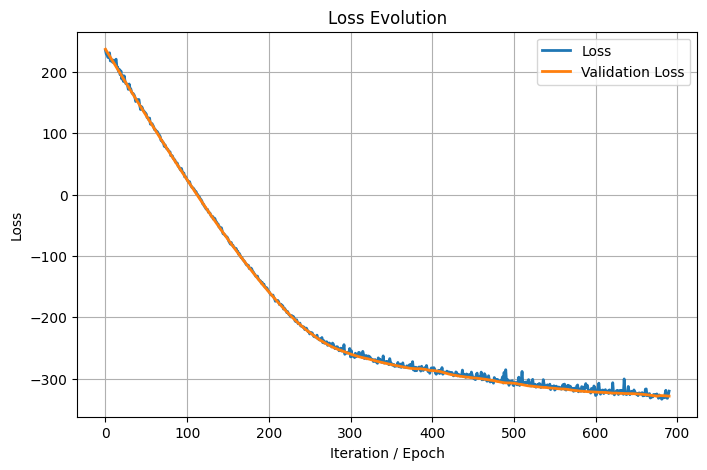

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.2767e+00,  1.3054e+00,  1.3528e+00,  1.4047e+00,  1.2322e+00,
         1.6601e+00,  7.9021e-01, -1.2541e-01,  4.4919e-01,  3.4590e+00,
         1.6411e+00,  1.6411e+00, -8.8633e+00,  1.1043e+00,  1.1121e+00,
         1.2725e+00,  1.0870e+00,  1.4309e+00,  5.7829e-01,  4.6743e-01,
         1.7274e+00,  2.8492e+00,  1.6411e+00,  1.6411e+00, -1.1640e-01,
         9.9639e-02, -4.8997e-03, -2.8672e-03,  3.9734e-02,  1.8406e-02,
         1.3535e-01,  2.5742e-01,  2.8211e-01,  3.4550e-01,  4.1569e-01,
         2.7891e-01,  7.2484e-01,  4.3302e-01,  2.8585e-01,  7.2466e-01,
         4.4228e-01,  4.3731e-02, -1.0104e-01, -3.8500e-01, -4.1899e-01,
         6.4851e-01,  6.9676e-01,  2.7614e-01,  9.8817e-02,  4.1553e-01,
         2.7210e-02,  9.2879e-02,  4.3996e-01,  2.2323e-01,  1.5840e-01,
        -1.9987e-01, -3.0333e-01, -2.9969e-01, -2.4057e-01, -1.8410e-01,
        -1.8723e-01, -8.8696e-02, -1.6667e-02, -6.8559e-02, -7.9224e-02,
         7.0635e-03, -4.6939e-02, -4.3954e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.4854
KLD Gaussian Train Data:  0.1107
KLD Copula   Train Data:  -0.0018
KLD GTM      Test  Data:  1.4841
KLD Gaussian Test  Data:  0.1037
KLD Copula   Test  Data:  0.0015


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

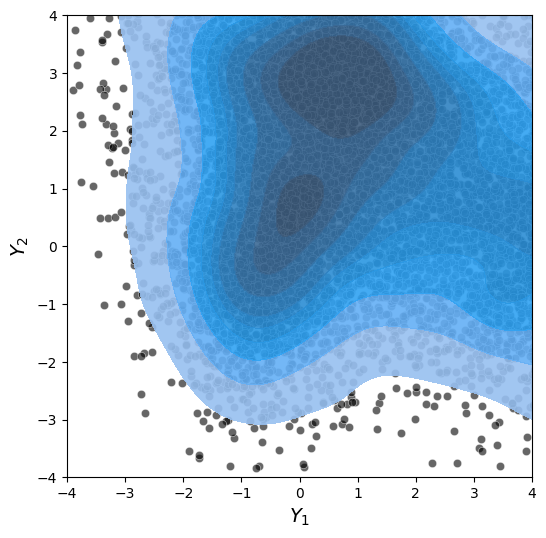

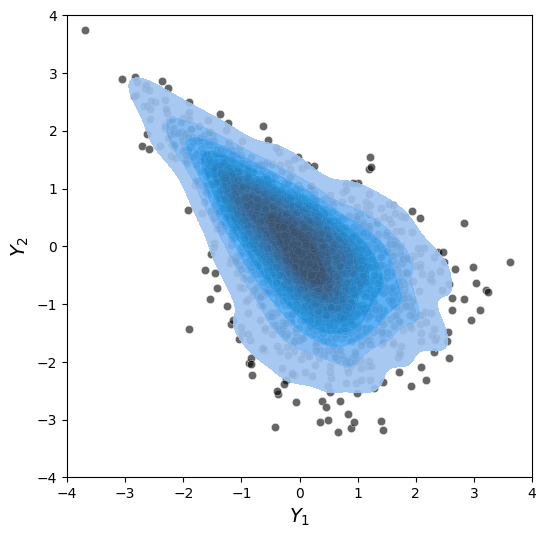

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


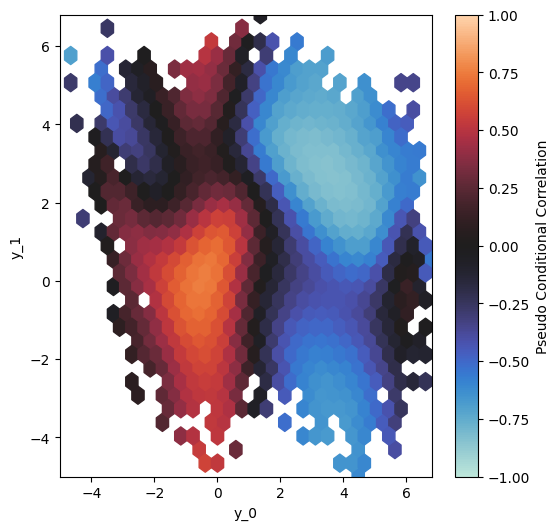

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


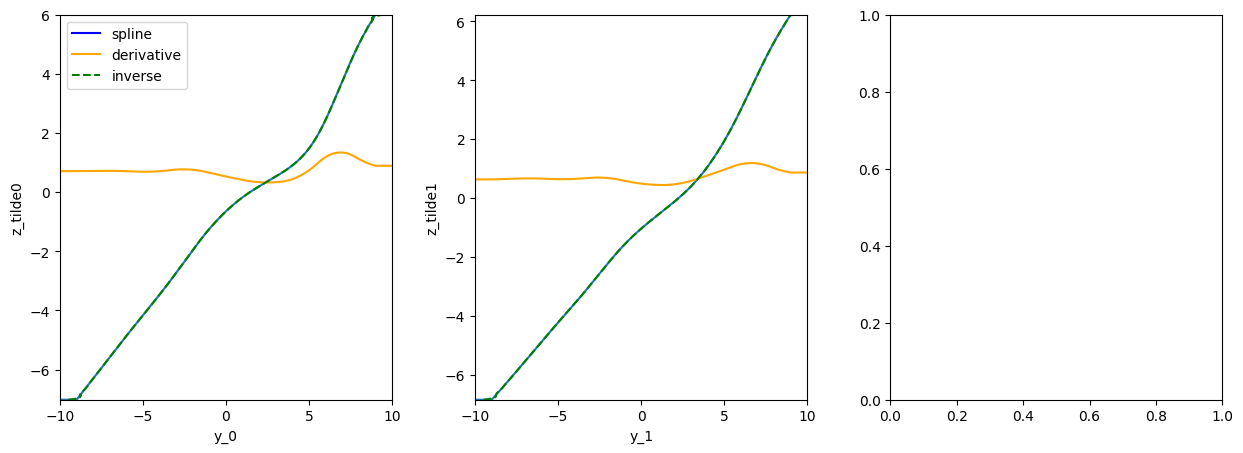

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


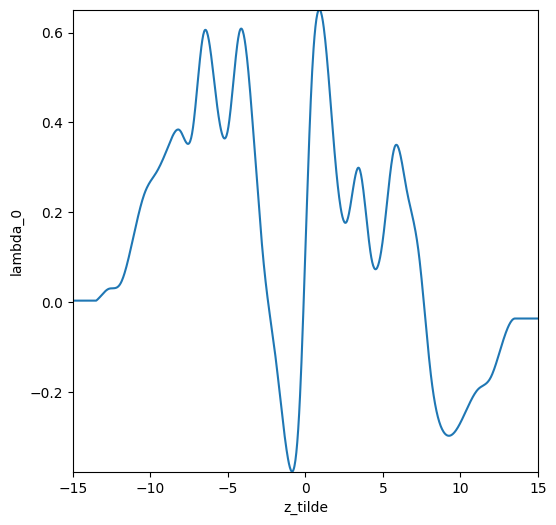

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


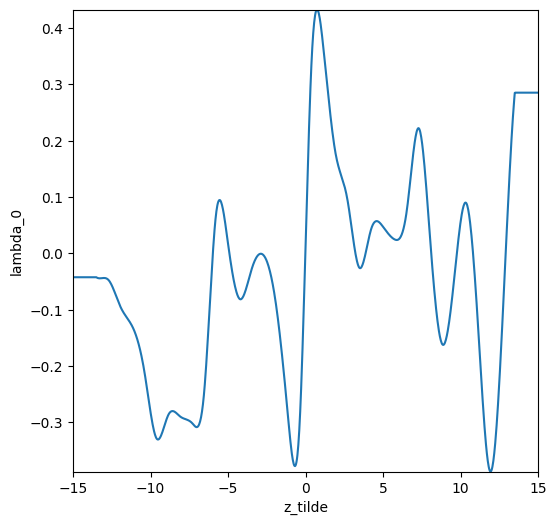

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


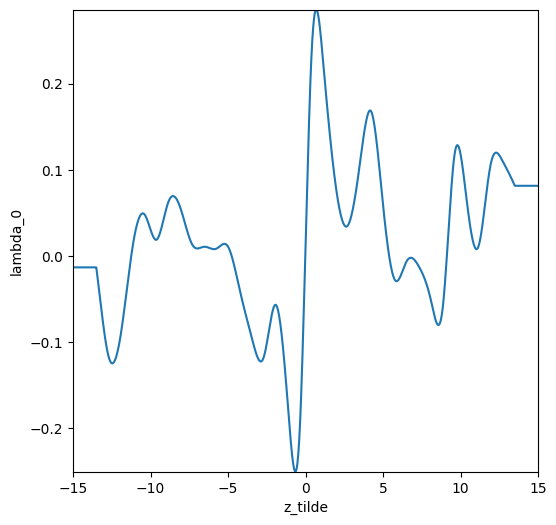

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)